In [1]:
# ============================================================================
# CELL 1: INSTALL ALL DEPENDENCIES
# ============================================================================
!pip install ftfy regex tqdm pycocotools --quiet
!pip install transformers[torch] --quiet
!pip install accelerate --quiet
!pip install matplotlib seaborn faiss-cpu --quiet
!pip install sentencepiece timm --quiet
!pip install nltk rouge-score scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency res

In [2]:
import os, json, time, gc, warnings
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Using device: {device}")

✓ Using device: cuda


In [10]:
# ============================================================================
# CELL 2: SETUP PERSISTENT STORAGE PATHS
# ============================================================================

# Create directories for persistent storage
STORAGE_ROOT = "/kaggle/working/vlm_benchmark_storage"
MODELS_DIR = os.path.join(STORAGE_ROOT, "models")
EMBEDDINGS_DIR = os.path.join(STORAGE_ROOT, "embeddings")
CAPTIONS_DIR = os.path.join(STORAGE_ROOT, "captions")
RESULTS_DIR = os.path.join(STORAGE_ROOT, "results")
PLOTS_DIR = os.path.join(STORAGE_ROOT, "plots")

for dir_path in [STORAGE_ROOT, MODELS_DIR, EMBEDDINGS_DIR, CAPTIONS_DIR, RESULTS_DIR, PLOTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print("✓ Storage directories created:")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Embeddings: {EMBEDDINGS_DIR}")
print(f"  - Captions: {CAPTIONS_DIR}")
print(f"  - Results: {RESULTS_DIR}")
print(f"  - Plots: {PLOTS_DIR}")

✓ Storage directories created:
  - Models: /kaggle/working/vlm_benchmark_storage/models
  - Embeddings: /kaggle/working/vlm_benchmark_storage/embeddings
  - Captions: /kaggle/working/vlm_benchmark_storage/captions
  - Results: /kaggle/working/vlm_benchmark_storage/results
  - Plots: /kaggle/working/vlm_benchmark_storage/plots


In [3]:
# ============================================================================
# CELL 3: COMPREHENSIVE UTILITY FUNCTIONS
# ============================================================================

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

# ---------------------- Storage Helper ----------------------
def save_json(data, filepath):
    """Save data as JSON"""
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"  ✓ Saved: {filepath}")

def load_json(filepath):
    """Load data from JSON"""
    with open(filepath, 'r') as f:
        return json.load(f)

# ---------------------- Retrieval Metrics ----------------------
def recall_at_k(sim_matrix, k):
    """Calculate Recall@K for retrieval tasks"""
    hits = sum(idx in np.argsort(-sim_matrix[idx])[:k] for idx in range(sim_matrix.shape[0]))
    return hits / sim_matrix.shape[0]

def mean_reciprocal_rank(sim_matrix):
    """Calculate Mean Reciprocal Rank (MRR)"""
    reciprocal_ranks = []
    for idx in range(sim_matrix.shape[0]):
        sorted_indices = np.argsort(-sim_matrix[idx])
        rank = np.where(sorted_indices == idx)[0][0] + 1
        reciprocal_ranks.append(1.0 / rank)
    return np.mean(reciprocal_ranks)

# ---------------------- Captioning Metrics ----------------------
def compute_bleu(references, hypotheses):
    """Compute BLEU-1, BLEU-2, BLEU-3, BLEU-4"""
    smoothing = SmoothingFunction().method1
    bleu_scores = {1: [], 2: [], 3: [], 4: []}
    
    for ref, hyp in zip(references, hypotheses):
        ref_tokens = [r.split() for r in ref]
        hyp_tokens = hyp.split() if isinstance(hyp, str) else hyp
        
        for n in [1, 2, 3, 4]:
            weights = tuple([1.0/n] * n + [0.0] * (4-n))
            score = sentence_bleu(ref_tokens, hyp_tokens, weights=weights, smoothing_function=smoothing)
            bleu_scores[n].append(score)
    
    return {f'bleu{n}': np.mean(scores) for n, scores in bleu_scores.items()}

def compute_rouge(references, hypotheses):
    """Compute ROUGE-1, ROUGE-2, ROUGE-L"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for ref_list, hyp in zip(references, hypotheses):
        ref = ref_list[0] if isinstance(ref_list, list) else ref_list
        scores = scorer.score(ref, hyp)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    return {k: np.mean(v) for k, v in rouge_scores.items()}

def compute_meteor(references, hypotheses):
    """Compute METEOR score"""
    meteor_scores = []
    for ref_list, hyp in zip(references, hypotheses):
        ref_tokens = [r.split() for r in ref_list]
        hyp_tokens = hyp.split() if isinstance(hyp, str) else hyp
        score = meteor_score([ref_tokens[0]], hyp_tokens)
        meteor_scores.append(score)
    return np.mean(meteor_scores)

def compute_cider_simple(references, hypotheses):
    """Simplified CIDEr-like score using TF-IDF"""
    from sklearn.feature_extraction.text import TfidfVectorizer
    scores = []
    for refs, hyp in zip(references, hypotheses):
        corpus = refs + [hyp]
        vectorizer = TfidfVectorizer()
        try:
            tfidf_matrix = vectorizer.fit_transform(corpus)
            hyp_vec = tfidf_matrix[-1]
            ref_vecs = tfidf_matrix[:-1]
            sims = cosine_similarity(hyp_vec, ref_vecs).flatten()
            scores.append(np.mean(sims))
        except:
            scores.append(0.0)
    return np.mean(scores)

# ---------------------- Classification Metrics ----------------------
def compute_classification_metrics(y_true, y_pred, y_probs, class_names=None):
    """Compute comprehensive classification metrics"""
    metrics = {}
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    if y_probs is not None:
        top5_preds = np.argsort(y_probs, axis=1)[:, -5:]
        metrics['top5_accuracy'] = np.mean([y_true[i] in top5_preds[i] for i in range(len(y_true))])
        pred_confidences = np.max(y_probs, axis=1)
        metrics['mean_confidence'] = np.mean(pred_confidences)
        metrics['ece'] = compute_ece(y_true, y_pred, y_probs)
    
    return metrics

def compute_ece(y_true, y_pred, y_probs, n_bins=10):
    """Compute Expected Calibration Error"""
    confidences = np.max(y_probs, axis=1)
    accuracies = (y_true == y_pred).astype(float)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

# ---------------------- Efficiency Metrics ----------------------
def measure_latency_and_memory(func, *args, **kwargs):
    """Measure inference latency and peak GPU memory"""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
    
    start = time.time()
    result = func(*args, **kwargs)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    latency = time.time() - start
    mem = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0
    return result, latency, mem

def compute_throughput(model_func, test_samples, batch_size, num_iterations=3):
    """Compute throughput (images/second)"""
    times = []
    for _ in range(num_iterations):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.time()
        model_func(test_samples[:batch_size])
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        times.append(time.time() - start)
    avg_time = np.mean(times)
    return batch_size / avg_time

def get_batches(files, batch_size):
    """Generate batches from file list"""
    for i in range(0, len(files), batch_size):
        yield files[i:i+batch_size]

print("✓ All utility functions loaded!")

✓ All utility functions loaded!


In [4]:
# ============================================================================
# CELL 4: LOAD COCO DATASET
# ============================================================================

DATA_DIR = '/kaggle/input/coco-image-caption'
IMG_DIR = os.path.join(DATA_DIR, 'val2017/val2017')
ANN_PATH = os.path.join(DATA_DIR, 'annotations_trainval2017/annotations/captions_val2017.json')
INSTANCES_PATH = os.path.join(DATA_DIR, 'annotations_trainval2017/annotations/instances_val2017.json')

# Load captions
coco_caps = COCO(ANN_PATH)
img_ids = coco_caps.getImgIds()
imgs_metadata = coco_caps.loadImgs(img_ids)
image_files = [img['file_name'] for img in imgs_metadata]
imgid_to_fname = {img['id']: img['file_name'] for img in imgs_metadata}
fname_to_imgid_map = {img['file_name']: img['id'] for img in imgs_metadata}
fname_to_captions = {img['file_name']: [a['caption'] for a in coco_caps.imgToAnns[img['id']]] for img in imgs_metadata}
references = [fname_to_captions[fname] for fname in image_files]

# Load object categories
coco_inst = COCO(INSTANCES_PATH)
categories = coco_inst.loadCats(coco_inst.getCatIds())
category_names = [cat['name'] for cat in categories]
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
text_prompts = [f"a photo of a {cat}" for cat in category_names]

print(f"✓ Loaded {len(image_files)} COCO val2017 images")
print(f"✓ {len(category_names)} object categories for classification")

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
✓ Loaded 5000 COCO val2017 images
✓ 80 object categories for classification


In [ ]:
# ============================================================================
# CLIP: LOAD MODEL
# ============================================================================

from transformers import CLIPProcessor, CLIPModel

print("\n" + "="*60)
print("CLIP EVALUATION")
print("="*60)

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_model.eval()
print("✓ CLIP model loaded")

# ============================================================================
# CLIP: FEATURE EXTRACTION & CACHING
# ============================================================================

CLIP_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "clip_img_embeds.npy")
CLIP_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "clip_cap_embeds.npy")
BATCH_SIZE = 64

if all(os.path.exists(p) for p in [CLIP_IMG_EMB, CLIP_CAP_EMB]):
    print("Loading CLIP features from cache...")
    clip_img_embeds = np.load(CLIP_IMG_EMB)
    clip_cap_embeds = np.load(CLIP_CAP_EMB)
else:
    print(f"Extracting CLIP features for {len(image_files)} images...")
    img_embeds, cap_embeds = [], []
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), total=len(image_files)//BATCH_SIZE):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        img_inputs = clip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            img_feat = clip_model.get_image_features(**img_inputs).cpu().numpy()
        img_embeds.append(img_feat)
        
        for fname in batch_files:
            caps = fname_to_captions[fname]
            text_inputs = clip_processor(text=caps, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                text_feat = clip_model.get_text_features(**text_inputs).cpu().numpy()
            cap_embeds.append(text_feat.mean(axis=0))
    
    clip_img_embeds = np.vstack(img_embeds)
    clip_cap_embeds = np.vstack(cap_embeds)
    
    np.save(CLIP_IMG_EMB, clip_img_embeds)
    np.save(CLIP_CAP_EMB, clip_cap_embeds)
    print("✓ CLIP features cached")

# Normalize
clip_img_embeds_norm = clip_img_embeds / np.linalg.norm(clip_img_embeds, axis=1, keepdims=True)
clip_cap_embeds_norm = clip_cap_embeds / np.linalg.norm(clip_cap_embeds, axis=1, keepdims=True)

# ============================================================================
# CLIP: RETRIEVAL METRICS
# ============================================================================

clip_sim_matrix = np.dot(clip_img_embeds_norm, clip_cap_embeds_norm.T)

clip_retrieval = {}
for k in [1, 5, 10, 50]:
    clip_retrieval[f'recall@{k}'] = recall_at_k(clip_sim_matrix, k)
    print(f"  Recall@{k}: {clip_retrieval[f'recall@{k}']:.4f}")

clip_retrieval['mrr'] = mean_reciprocal_rank(clip_sim_matrix)
median_ranks = [np.where(np.argsort(-clip_sim_matrix[idx]) == idx)[0][0] + 1 
                for idx in range(clip_sim_matrix.shape[0])]
clip_retrieval['median_rank'] = np.median(median_ranks)
print(f"  MRR: {clip_retrieval['mrr']:.4f}")
print(f"  Median Rank: {clip_retrieval['median_rank']:.1f}")

# ============================================================================
# CLIP: ZERO-SHOT CLASSIFICATION
# ============================================================================

print("\nCLIP: Zero-Shot Classification...")
text_inputs = clip_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs).cpu().numpy()
text_features = text_features / np.linalg.norm(text_features, axis=1, keepdims=True)

y_true, y_pred, y_probs_list = [], [], []
for idx, fname in enumerate(tqdm(image_files[:1000])):
    img_id = fname_to_imgid_map[fname]
    ann_ids = coco_inst.getAnnIds(imgIds=img_id)
    if len(ann_ids) == 0:
        continue
    gt_cat_name = cat_id_to_name.get(coco_inst.loadAnns(ann_ids)[0]['category_id'])
    if not gt_cat_name or gt_cat_name not in category_names:
        continue
    
    y_true.append(category_names.index(gt_cat_name))
    img_feat = clip_img_embeds_norm[idx:idx+1]
    logits = np.dot(img_feat, text_features.T)[0]
    probs = np.exp(logits) / np.sum(np.exp(logits))
    y_probs_list.append(probs)
    y_pred.append(np.argmax(probs))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs_list)

clip_classification = compute_classification_metrics(y_true, y_pred, y_probs, category_names)
print(f"  Accuracy: {clip_classification['accuracy']:.4f}")
print(f"  Top-5: {clip_classification['top5_accuracy']:.4f}")
print(f"  F1: {clip_classification['f1_macro']:.4f}")
print(f"  ECE: {clip_classification['ece']:.4f}")

# ============================================================================
# CLIP: EFFICIENCY METRICS
# ============================================================================

def single_clip_infer(fname):
    img = Image.open(os.path.join(IMG_DIR, fname))
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        return clip_model.get_image_features(**inputs)

_, clip_latency, clip_memory = measure_latency_and_memory(single_clip_infer, image_files[0])

def batch_clip_infer(fnames):
    imgs = [Image.open(os.path.join(IMG_DIR, f)) for f in fnames]
    inputs = clip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return clip_model.get_image_features(**inputs)

clip_throughput = compute_throughput(batch_clip_infer, image_files[:64], batch_size=32)

print(f"  Latency: {clip_latency*1000:.2f} ms")
print(f"  Memory: {clip_memory:.0f} MB")
print(f"  Throughput: {clip_throughput:.2f} imgs/sec")

# ============================================================================
# CLIP: SAVE RESULTS
# ============================================================================

clip_results = {
    'model': 'CLIP',
    'retrieval': clip_retrieval,
    'classification': {k: float(v) if isinstance(v, np.floating) else v 
                      for k, v in clip_classification.items() if not k.startswith('per_class')},
    'captioning': None,
    'efficiency': {
        'latency_ms': float(clip_latency * 1000),
        'memory_mb': float(clip_memory),
        'throughput': float(clip_throughput)
    }
}

save_json(clip_results, os.path.join(RESULTS_DIR, 'clip_results.json'))
print("\n✓ CLIP evaluation complete and saved!")

In [36]:
# ============================================================================
# BLIP: LOAD MODELS
# ============================================================================

from transformers import BlipProcessor, BlipForConditionalGeneration, BlipModel
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image

print("\n" + "="*60)
print("BLIP EVALUATION - CORRECTED VERSION")
print("="*60)

# Load models
print("\n📦 Loading BLIP models...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_retrieval_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_model.eval()
blip_retrieval_model.eval()
print("✓ BLIP models loaded successfully")

# Generation config
generation_config = {
    'max_new_tokens': 50,
    'min_length': 10,
    'num_beams': 5,
    'early_stopping': True,
    'repetition_penalty': 1.2,
}
print("✓ Generation config set")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



BLIP EVALUATION - CORRECTED VERSION

📦 Loading BLIP models...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

✓ BLIP models loaded successfully
✓ Generation config set


In [37]:
# ============================================================================
# BLIP: CAPTION GENERATION
# ============================================================================

print("\n" + "="*60)
print("BLIP: CAPTION GENERATION")
print("="*60)

BLIP_CAP_FILE = os.path.join(CAPTIONS_DIR, "blip_captions.txt")
BATCH_SIZE = 16

if os.path.exists(BLIP_CAP_FILE):
    print("\n📂 Loading BLIP captions from cache...")
    with open(BLIP_CAP_FILE) as f:
        blip_captions = f.read().splitlines()
    print(f"✓ Loaded {len(blip_captions)} cached captions")
else:
    print(f"\n🎨 Generating BLIP captions for {len(image_files)} images...")
    blip_captions = []
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                           total=len(image_files)//BATCH_SIZE,
                           desc="Generating captions"):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        inputs = blip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = blip_model.generate(**inputs, **generation_config)
            batch_caps = blip_processor.batch_decode(outputs, skip_special_tokens=True)
        
        blip_captions.extend(batch_caps)
        
        if len(blip_captions) % 500 == 0:
            torch.cuda.empty_cache()
    
    # Save to cache
    with open(BLIP_CAP_FILE, "w") as f:
        f.write('\n'.join(blip_captions))
    print(f"✓ Generated and cached {len(blip_captions)} captions")

# Compute captioning metrics
print("\n📊 Computing BLIP captioning metrics...")
bleu_scores = compute_bleu(references, blip_captions)
rouge_scores = compute_rouge(references, blip_captions)
meteor = compute_meteor(references, blip_captions)
cider = compute_cider_simple(references, blip_captions)

blip_captioning = {
    **bleu_scores,
    **rouge_scores,
    'meteor': meteor,
    'cider': cider
}

print("\n📈 Captioning Results:")
for metric, score in blip_captioning.items():
    print(f"  {metric.upper()}: {score:.4f}")

print("\n" + "="*60)
print("CAPTION GENERATION COMPLETE")
print("="*60)


BLIP: CAPTION GENERATION

📂 Loading BLIP captions from cache...
✓ Loaded 5000 cached captions

📊 Computing BLIP captioning metrics...

📈 Captioning Results:
  BLEU1: 0.7093
  BLEU2: 0.5246
  BLEU3: 0.3681
  BLEU4: 0.2597
  ROUGE1: 0.4556
  ROUGE2: 0.1949
  ROUGEL: 0.4109
  METEOR: 0.3187
  CIDER: 0.2360

CAPTION GENERATION COMPLETE


In [39]:
# ============================================================================
# BLIP: FEATURE EXTRACTION FOR RETRIEVAL - CORRECTED
# ============================================================================

print("\n" + "="*60)
print("BLIP: FEATURE EXTRACTION (CORRECTED)")
print("="*60)

BLIP_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "blip_img_embeds.npy")
BLIP_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "blip_cap_embeds.npy")
BATCH_SIZE = 32

# Check if cached
if all(os.path.exists(p) for p in [BLIP_IMG_EMB, BLIP_CAP_EMB]):
    print("\n📂 Loading BLIP retrieval features from cache...")
    blip_img_embeds = np.load(BLIP_IMG_EMB)
    blip_cap_embeds = np.load(BLIP_CAP_EMB)
    print(f"✓ Loaded cached embeddings:")
    print(f"  Images: {blip_img_embeds.shape}")
    print(f"  Captions: {blip_cap_embeds.shape}")
else:
    print(f"\n🔬 Extracting BLIP features for retrieval...")
    img_embeds = []
    cap_embeds = []
    
    # =========================================================================
    # EXTRACT IMAGE FEATURES (BATCHED) - USING POOLER OUTPUT
    # =========================================================================
    print("\n📸 Step 1/2: Extracting image features (batched)...")
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                           total=len(image_files)//BATCH_SIZE,
                           desc="Image features"):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        img_inputs = blip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            # ✅ CORRECTED: Use vision_model to get pooled output
            vision_outputs = blip_retrieval_model.vision_model(
                pixel_values=img_inputs['pixel_values'],
                return_dict=True
            )
            # Get pooled output (CLS token) - shape: (batch, 768)
            img_feat = vision_outputs.pooler_output.cpu().numpy()
        
        img_embeds.append(img_feat)
        
        if len(img_embeds) % 10 == 0:
            torch.cuda.empty_cache()
    
    blip_img_embeds = np.vstack(img_embeds)
    print(f"✓ Image embeddings extracted: {blip_img_embeds.shape}")
    
    # =========================================================================
    # EXTRACT TEXT FEATURES (ONE CAPTION PER IMAGE) - USING POOLER OUTPUT
    # =========================================================================
    print("\n📝 Step 2/2: Extracting text features (one caption per image)...")
    for fname in tqdm(image_files, desc="Text features"):
        caps = fname_to_captions[fname]
        # ✅ CORRECTED: Use ONLY first caption
        first_caption = caps[0]
        
        text_inputs = blip_processor(
            text=first_caption, 
            return_tensors="pt", 
            padding=True, 
            truncation=True
        ).to(device)
        
        with torch.no_grad():
            # ✅ CORRECTED: Use text_model to get pooled output
            text_outputs = blip_retrieval_model.text_model(
                input_ids=text_inputs['input_ids'],
                attention_mask=text_inputs['attention_mask'],
                return_dict=True
            )
            # Get pooled output - shape: (1, 768)
            text_feat = text_outputs.pooler_output.cpu().numpy()
        
        cap_embeds.append(text_feat[0])
        
        if len(cap_embeds) % 1000 == 0:
            torch.cuda.empty_cache()
    
    blip_cap_embeds = np.vstack(cap_embeds)
    print(f"✓ Caption embeddings extracted: {blip_cap_embeds.shape}")
    
    # Verify shapes match
    print(f"\n🔍 Verification:")
    print(f"  Image embeddings: {blip_img_embeds.shape}")
    print(f"  Caption embeddings: {blip_cap_embeds.shape}")
    
    assert blip_img_embeds.shape == blip_cap_embeds.shape, \
        f"Shape mismatch: images {blip_img_embeds.shape} vs captions {blip_cap_embeds.shape}"
    print(f"✓ Shape verification passed!")
    
    # Save to cache
    np.save(BLIP_IMG_EMB, blip_img_embeds)
    np.save(BLIP_CAP_EMB, blip_cap_embeds)
    print(f"\n💾 Saved embeddings to cache")

# Normalize embeddings
print(f"\n🔧 Normalizing embeddings...")
blip_img_embeds_norm = blip_img_embeds / np.linalg.norm(blip_img_embeds, axis=1, keepdims=True)
blip_cap_embeds_norm = blip_cap_embeds / np.linalg.norm(blip_cap_embeds, axis=1, keepdims=True)
print(f"✓ Normalization complete")

print("\n" + "="*60)
print("FEATURE EXTRACTION COMPLETE")
print("="*60)


BLIP: FEATURE EXTRACTION (CORRECTED)

📂 Loading BLIP retrieval features from cache...
✓ Loaded cached embeddings:
  Images: (5000, 512)
  Captions: (5000, 512)

🔧 Normalizing embeddings...
✓ Normalization complete

FEATURE EXTRACTION COMPLETE


In [42]:
# ============================================================================
# BLIP DIAGNOSTIC: ANALYZE FEATURE EXTRACTION
# ============================================================================

print("\n" + "="*60)
print("BLIP DIAGNOSTIC ANALYSIS")
print("="*60)

# =========================================================================
# 1. CHECK BLIP MODEL ARCHITECTURE
# =========================================================================

print("\n🔍 Step 1: Analyzing BLIP model architecture...")
print(f"\nBLIP Retrieval Model structure:")
print(f"  Type: {type(blip_retrieval_model)}")
print(f"  Has vision_model: {hasattr(blip_retrieval_model, 'vision_model')}")
print(f"  Has text_model: {hasattr(blip_retrieval_model, 'text_model')}")
print(f"  Has get_image_features: {hasattr(blip_retrieval_model, 'get_image_features')}")
print(f"  Has get_text_features: {hasattr(blip_retrieval_model, 'get_text_features')}")

# Check available methods
print(f"\nAvailable methods:")
blip_methods = [m for m in dir(blip_retrieval_model) if not m.startswith('_')]
for method in ['vision_model', 'text_model', 'visual_projection', 'text_projection', 'get_image_features', 'get_text_features']:
    if method in blip_methods:
        print(f"  ✓ {method}")
    else:
        print(f"  ✗ {method} (not found)")

# =========================================================================
# 2. TEST IMAGE FEATURE EXTRACTION - MULTIPLE METHODS
# =========================================================================

print("\n" + "="*60)
print("🔍 Step 2: Testing image feature extraction methods...")
print("="*60)

# Load test image
test_img = Image.open(os.path.join(IMG_DIR, image_files[0]))
print(f"\nTest image: {image_files[0]}")

# Process image
img_inputs = blip_processor(images=test_img, return_tensors="pt").to(device)
print(f"Processed input keys: {img_inputs.keys()}")
print(f"Pixel values shape: {img_inputs['pixel_values'].shape}")

with torch.no_grad():
    # Method 1: Try get_image_features()
    print("\n--- Method 1: get_image_features() ---")
    try:
        img_feat_1 = blip_retrieval_model.get_image_features(**img_inputs)
        print(f"✓ Output type: {type(img_feat_1)}")
        print(f"✓ Output shape: {img_feat_1.shape}")
        print(f"  Sample values (first 5): {img_feat_1[0, :5].cpu().numpy()}")
    except Exception as e:
        print(f"✗ Error: {e}")
    
    # Method 2: Try vision_model
    print("\n--- Method 2: vision_model() ---")
    try:
        vision_outputs = blip_retrieval_model.vision_model(
            pixel_values=img_inputs['pixel_values'],
            return_dict=True
        )
        print(f"✓ Output type: {type(vision_outputs)}")
        print(f"✓ Output keys: {vision_outputs.keys() if hasattr(vision_outputs, 'keys') else 'N/A'}")
        
        if hasattr(vision_outputs, 'pooler_output') and vision_outputs.pooler_output is not None:
            print(f"✓ pooler_output shape: {vision_outputs.pooler_output.shape}")
            print(f"  Sample values (first 5): {vision_outputs.pooler_output[0, :5].cpu().numpy()}")
        else:
            print(f"✗ pooler_output not available")
        
        if hasattr(vision_outputs, 'last_hidden_state'):
            print(f"✓ last_hidden_state shape: {vision_outputs.last_hidden_state.shape}")
        
    except Exception as e:
        print(f"✗ Error: {e}")
    
    # Method 3: Full model forward pass
    print("\n--- Method 3: Full model forward() ---")
    try:
        full_outputs = blip_retrieval_model(**img_inputs, return_dict=True)
        print(f"✓ Output type: {type(full_outputs)}")
        print(f"✓ Output keys: {full_outputs.keys() if hasattr(full_outputs, 'keys') else 'N/A'}")
        
        # Check for common embedding attributes
        for attr in ['image_embeds', 'vision_model_output', 'pooler_output', 'last_hidden_state']:
            if hasattr(full_outputs, attr):
                val = getattr(full_outputs, attr)
                if val is not None:
                    print(f"✓ {attr} shape: {val.shape}")
    except Exception as e:
        print(f"✗ Error: {e}")

# =========================================================================
# 3. TEST TEXT FEATURE EXTRACTION - MULTIPLE METHODS
# =========================================================================

print("\n" + "="*60)
print("🔍 Step 3: Testing text feature extraction methods...")
print("="*60)

test_caption = fname_to_captions[image_files[0]][0]
print(f"\nTest caption: '{test_caption}'")

# Process text
text_inputs = blip_processor(text=test_caption, return_tensors="pt", padding=True, truncation=True).to(device)
print(f"Processed input keys: {text_inputs.keys()}")
print(f"Input IDs shape: {text_inputs['input_ids'].shape}")

with torch.no_grad():
    # Method 1: Try get_text_features()
    print("\n--- Method 1: get_text_features() ---")
    try:
        text_feat_1 = blip_retrieval_model.get_text_features(**text_inputs)
        print(f"✓ Output type: {type(text_feat_1)}")
        print(f"✓ Output shape: {text_feat_1.shape}")
        print(f"  Sample values (first 5): {text_feat_1[0, :5].cpu().numpy() if len(text_feat_1.shape) == 2 else text_feat_1[0, 0, :5].cpu().numpy()}")
    except Exception as e:
        print(f"✗ Error: {e}")
    
    # Method 2: Try text_model
    print("\n--- Method 2: text_model() ---")
    try:
        text_outputs = blip_retrieval_model.text_model(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            return_dict=True
        )
        print(f"✓ Output type: {type(text_outputs)}")
        print(f"✓ Output keys: {text_outputs.keys() if hasattr(text_outputs, 'keys') else 'N/A'}")
        
        if hasattr(text_outputs, 'pooler_output') and text_outputs.pooler_output is not None:
            print(f"✓ pooler_output shape: {text_outputs.pooler_output.shape}")
            print(f"  Sample values (first 5): {text_outputs.pooler_output[0, :5].cpu().numpy()}")
        else:
            print(f"✗ pooler_output not available")
        
        if hasattr(text_outputs, 'last_hidden_state'):
            print(f"✓ last_hidden_state shape: {text_outputs.last_hidden_state.shape}")
            
    except Exception as e:
        print(f"✗ Error: {e}")

# =========================================================================
# 4. ANALYZE CURRENT EMBEDDINGS (if they exist)
# =========================================================================

print("\n" + "="*60)
print("🔍 Step 4: Analyzing current embeddings...")
print("="*60)

if 'blip_img_embeds' in locals():
    print(f"\nImage embeddings:")
    print(f"  Shape: {blip_img_embeds.shape}")
    print(f"  Mean: {blip_img_embeds.mean():.6f}")
    print(f"  Std: {blip_img_embeds.std():.6f}")
    print(f"  Min: {blip_img_embeds.min():.6f}")
    print(f"  Max: {blip_img_embeds.max():.6f}")
    print(f"  First sample (first 10 dims): {blip_img_embeds[0, :10]}")
    
    print(f"\nCaption embeddings:")
    print(f"  Shape: {blip_cap_embeds.shape}")
    print(f"  Mean: {blip_cap_embeds.mean():.6f}")
    print(f"  Std: {blip_cap_embeds.std():.6f}")
    print(f"  Min: {blip_cap_embeds.min():.6f}")
    print(f"  Max: {blip_cap_embeds.max():.6f}")
    print(f"  First sample (first 10 dims): {blip_cap_embeds[0, :10]}")
    
    # Check if embeddings are identical or very similar
    print(f"\n🔍 Checking embedding diversity...")
    img_unique = len(np.unique(blip_img_embeds.round(decimals=4)))
    cap_unique = len(np.unique(blip_cap_embeds.round(decimals=4)))
    print(f"  Image unique values: {img_unique}")
    print(f"  Caption unique values: {cap_unique}")
    
    # Check diagonal vs off-diagonal similarities
    if 'blip_sim_matrix' in locals():
        print(f"\n🔍 Analyzing similarity matrix...")
        diagonal = np.diag(blip_sim_matrix)
        off_diagonal = blip_sim_matrix[np.triu_indices_from(blip_sim_matrix, k=1)]
        
        print(f"  Diagonal (self-similarity):")
        print(f"    Mean: {diagonal.mean():.6f}")
        print(f"    Std: {diagonal.std():.6f}")
        print(f"    Min: {diagonal.min():.6f}")
        print(f"    Max: {diagonal.max():.6f}")
        
        print(f"  Off-diagonal (cross-similarity):")
        print(f"    Mean: {off_diagonal.mean():.6f}")
        print(f"    Std: {off_diagonal.std():.6f}")
        print(f"    Min: {off_diagonal.min():.6f}")
        print(f"    Max: {off_diagonal.max():.6f}")
        
        # Check if all similarities are nearly identical
        if diagonal.std() < 0.01 and off_diagonal.std() < 0.01:
            print(f"\n⚠️ WARNING: Similarities are nearly uniform - embeddings may be constant!")

# =========================================================================
# 5. COMPARE WITH CLIP (working model)
# =========================================================================

print("\n" + "="*60)
print("🔍 Step 5: Comparing with CLIP (reference)...")
print("="*60)

# Load CLIP embeddings for comparison
CLIP_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "clip_img_embeds.npy")
CLIP_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "clip_cap_embeds.npy")

if os.path.exists(CLIP_IMG_EMB) and os.path.exists(CLIP_CAP_EMB):
    clip_img = np.load(CLIP_IMG_EMB)
    clip_cap = np.load(CLIP_CAP_EMB)
    
    print(f"\nCLIP embeddings (for reference):")
    print(f"  Image shape: {clip_img.shape}")
    print(f"  Caption shape: {clip_cap.shape}")
    print(f"  Image mean: {clip_img.mean():.6f}")
    print(f"  Image std: {clip_img.std():.6f}")
    print(f"  Caption mean: {clip_cap.mean():.6f}")
    print(f"  Caption std: {clip_cap.std():.6f}")
    
    if 'blip_img_embeds' in locals():
        print(f"\nBLIP vs CLIP comparison:")
        print(f"  BLIP image mean: {blip_img_embeds.mean():.6f} | CLIP: {clip_img.mean():.6f}")
        print(f"  BLIP image std: {blip_img_embeds.std():.6f} | CLIP: {clip_img.std():.6f}")
        print(f"  BLIP caption mean: {blip_cap_embeds.mean():.6f} | CLIP: {clip_cap.mean():.6f}")
        print(f"  BLIP caption std: {blip_cap_embeds.std():.6f} | CLIP: {clip_cap.std():.6f}")

print("\n" + "="*60)
print("DIAGNOSTIC ANALYSIS COMPLETE")
print("="*60)


BLIP DIAGNOSTIC ANALYSIS

🔍 Step 1: Analyzing BLIP model architecture...

BLIP Retrieval Model structure:
  Type: <class 'transformers.models.blip.modeling_blip.BlipModel'>
  Has vision_model: True
  Has text_model: True
  Has get_image_features: True
  Has get_text_features: True

Available methods:
  ✓ vision_model
  ✓ text_model
  ✓ visual_projection
  ✓ text_projection
  ✓ get_image_features
  ✓ get_text_features

🔍 Step 2: Testing image feature extraction methods...

Test image: 000000397133.jpg
Processed input keys: KeysView({'pixel_values': tensor([[[[ 0.0033, -0.2302, -0.2156,  ..., -1.5733, -1.6317, -1.6463],
          [-0.0842, -0.3324, -0.3178,  ..., -1.6171, -1.6025, -1.5149],
          [-0.0550, -0.3470, -0.4492,  ..., -1.5879, -1.5733, -1.0185],
          ...,
          [ 0.2515,  0.2369,  0.2223,  ..., -1.0623, -1.0477, -1.1207],
          [ 0.2661,  0.2661,  0.2515,  ..., -1.0769, -1.0915, -1.0915],
          [ 0.2953,  0.2953,  0.2807,  ..., -1.0331, -1.0915, -1.0769]

In [43]:
# ============================================================================
# BLIP FEATURE EXTRACTION
# ============================================================================

print("\n" + "="*60)
print("BLIP: CORRECTED FEATURE EXTRACTION")
print("="*60)

BLIP_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "blip_img_embeds_corrected.npy")
BLIP_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "blip_cap_embeds_corrected.npy")
BATCH_SIZE = 32

img_embeds = []
cap_embeds = []

# =========================================================================
# EXTRACT IMAGE FEATURES - USE VISION_MODEL POOLER OUTPUT
# =========================================================================
print("\n📸 Extracting image features (vision_model.pooler_output)...")
for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                       total=len(image_files)//BATCH_SIZE,
                       desc="Image features"):
    imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
    img_inputs = blip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # ✅ Use vision_model pooler_output (768-dim)
        vision_outputs = blip_retrieval_model.vision_model(
            pixel_values=img_inputs['pixel_values'],
            return_dict=True
        )
        img_feat = vision_outputs.pooler_output.cpu().numpy()
    
    img_embeds.append(img_feat)
    
    if len(img_embeds) % 10 == 0:
        torch.cuda.empty_cache()

blip_img_embeds_new = np.vstack(img_embeds)
print(f"✓ Image embeddings: {blip_img_embeds_new.shape}")

# =========================================================================
# EXTRACT TEXT FEATURES - USE TEXT_MODEL POOLER OUTPUT
# =========================================================================
print("\n📝 Extracting text features (text_model.pooler_output)...")
for fname in tqdm(image_files, desc="Text features"):
    first_caption = fname_to_captions[fname][0]
    
    text_inputs = blip_processor(
        text=first_caption, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    ).to(device)
    
    with torch.no_grad():
        # ✅ Use text_model pooler_output (768-dim)
        text_outputs = blip_retrieval_model.text_model(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            return_dict=True
        )
        text_feat = text_outputs.pooler_output.cpu().numpy()
    
    cap_embeds.append(text_feat[0])
    
    if len(cap_embeds) % 1000 == 0:
        torch.cuda.empty_cache()

blip_cap_embeds_new = np.vstack(cap_embeds)
print(f"✓ Caption embeddings: {blip_cap_embeds_new.shape}")

# =========================================================================
# APPLY PROJECTIONS TO ALIGN SPACES (768 -> 512)
# =========================================================================
print("\n🔧 Applying BLIP projection layers to align spaces...")

with torch.no_grad():
    # Project image embeddings (768 -> 512)
    img_embeds_tensor = torch.tensor(blip_img_embeds_new, dtype=torch.float32).to(device)
    img_embeds_projected = blip_retrieval_model.visual_projection(img_embeds_tensor)
    blip_img_embeds_final = img_embeds_projected.cpu().numpy()
    
    # Project text embeddings (768 -> 512)
    text_embeds_tensor = torch.tensor(blip_cap_embeds_new, dtype=torch.float32).to(device)
    text_embeds_projected = blip_retrieval_model.text_projection(text_embeds_tensor)
    blip_cap_embeds_final = text_embeds_projected.cpu().numpy()

print(f"✓ Projected image embeddings: {blip_img_embeds_final.shape}")
print(f"✓ Projected text embeddings: {blip_cap_embeds_final.shape}")

# =========================================================================
# NORMALIZE
# =========================================================================
print("\n🔧 Normalizing embeddings...")
blip_img_embeds_norm = blip_img_embeds_final / np.linalg.norm(blip_img_embeds_final, axis=1, keepdims=True)
blip_cap_embeds_norm = blip_cap_embeds_final / np.linalg.norm(blip_cap_embeds_final, axis=1, keepdims=True)

# =========================================================================
# TEST ALIGNMENT
# =========================================================================
print("\n🔍 Testing alignment...")
test_sim_matrix = np.dot(blip_img_embeds_norm, blip_cap_embeds_norm.T)
diagonal = np.diag(test_sim_matrix)

print(f"  Diagonal (self-similarity):")
print(f"    Mean: {diagonal.mean():.6f} (should be close to 1.0)")
print(f"    Std: {diagonal.std():.6f}")
print(f"    Min: {diagonal.min():.6f}")
print(f"    Max: {diagonal.max():.6f}")

if diagonal.mean() > 0.3:
    print(f"\n✅ SUCCESS! Embeddings are properly aligned!")
    
    # Save corrected embeddings
    np.save(BLIP_IMG_EMB, blip_img_embeds_final)
    np.save(BLIP_CAP_EMB, blip_cap_embeds_final)
    print(f"✓ Saved corrected embeddings")
    
    # Update variables for use
    blip_img_embeds = blip_img_embeds_final
    blip_cap_embeds = blip_cap_embeds_final
else:
    print(f"\n⚠️ WARNING: Alignment still poor (mean diagonal: {diagonal.mean():.4f})")
    print("This suggests BLIP may not be designed for this retrieval task")


BLIP: CORRECTED FEATURE EXTRACTION

📸 Extracting image features (vision_model.pooler_output)...


Image features: 157it [05:00,  1.91s/it]                         


✓ Image embeddings: (5000, 768)

📝 Extracting text features (text_model.pooler_output)...


Text features: 100%|██████████| 5000/5000 [00:53<00:00, 93.44it/s]


✓ Caption embeddings: (5000, 768)

🔧 Applying BLIP projection layers to align spaces...
✓ Projected image embeddings: (5000, 512)
✓ Projected text embeddings: (5000, 512)

🔧 Normalizing embeddings...

🔍 Testing alignment...
  Diagonal (self-similarity):
    Mean: 0.045200 (should be close to 1.0)
    Std: 0.031173
    Min: -0.062960
    Max: 0.166366

⚠️ WARNING: Alignment still poor (mean diagonal: 0.0452)
This suggests BLIP may not be designed for this retrieval task


In [45]:
# ============================================================================
# BLIP: CORRECT RETRIEVAL - USING MULTIMODAL EMBEDDINGS
# ============================================================================

print("\n" + "="*60)
print("BLIP: RETRIEVAL WITH MULTIMODAL EMBEDDINGS")
print("="*60)

# Clear previous attempts
import gc
gc.collect()
torch.cuda.empty_cache()

BLIP_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "blip_img_embeds_multimodal.npy")
BLIP_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "blip_cap_embeds_multimodal.npy")
BATCH_SIZE = 32

img_embeds = []
cap_embeds = []

# =========================================================================
# METHOD: Use vision + text encoders with MULTIMODAL OUTPUT
# =========================================================================

print("\n📸 Step 1: Extracting multimodal image features...")

for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                       total=len(image_files)//BATCH_SIZE,
                       desc="Image features"):
    imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
    
    # Process images
    inputs = blip_processor(images=imgs, text=[""] * len(imgs), return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get vision encoder output
        vision_outputs = blip_retrieval_model.vision_model(
            pixel_values=inputs['pixel_values'],
            return_dict=True
        )
        
        # Use last_hidden_state mean pooling (more robust than CLS)
        # Shape: (batch, 577, 768) -> (batch, 768)
        img_feat = vision_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    img_embeds.append(img_feat)
    
    if len(img_embeds) % 10 == 0:
        torch.cuda.empty_cache()

blip_img_embeds = np.vstack(img_embeds)
print(f"✓ Image embeddings: {blip_img_embeds.shape}")

print("\n📝 Step 2: Extracting multimodal text features...")

for fname in tqdm(image_files, desc="Text features"):
    first_caption = fname_to_captions[fname][0]
    
    # Process text
    inputs = blip_processor(text=first_caption, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        # Get text encoder output
        text_outputs = blip_retrieval_model.text_model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            return_dict=True
        )
        
        # Use last_hidden_state mean pooling
        # Shape: (1, seq_len, 768) -> (768,)
        text_feat = text_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    cap_embeds.append(text_feat[0])
    
    if len(cap_embeds) % 1000 == 0:
        torch.cuda.empty_cache()

blip_cap_embeds = np.vstack(cap_embeds)
print(f"✓ Caption embeddings: {blip_cap_embeds.shape}")

# =========================================================================
# NORMALIZE AND TEST
# =========================================================================

print("\n🔧 Normalizing...")
blip_img_embeds_norm = blip_img_embeds / np.linalg.norm(blip_img_embeds, axis=1, keepdims=True)
blip_cap_embeds_norm = blip_cap_embeds / np.linalg.norm(blip_cap_embeds, axis=1, keepdims=True)

# Test alignment
print("\n🔍 Testing alignment...")
test_sim = np.dot(blip_img_embeds_norm, blip_cap_embeds_norm.T)
diagonal = np.diag(test_sim)

print(f"  Diagonal (self-similarity):")
print(f"    Mean: {diagonal.mean():.6f}")
print(f"    Std: {diagonal.std():.6f}")
print(f"    Min: {diagonal.min():.6f}")
print(f"    Max: {diagonal.max():.6f}")

if diagonal.mean() > 0.2:
    print(f"\n✅ Acceptable alignment! Computing retrieval metrics...")
    
    # Save embeddings
    np.save(BLIP_IMG_EMB, blip_img_embeds)
    np.save(BLIP_CAP_EMB, blip_cap_embeds)
    
    # Compute retrieval metrics
    blip_sim_matrix = test_sim
    blip_retrieval = {}
    
    for k in [1, 5, 10, 50]:
        blip_retrieval[f'recall@{k}'] = recall_at_k(blip_sim_matrix, k)
        print(f"  Recall@{k}: {blip_retrieval[f'recall@{k}']:.4f}")
    
    blip_retrieval['mrr'] = mean_reciprocal_rank(blip_sim_matrix)
    median_ranks = [np.where(np.argsort(-blip_sim_matrix[idx]) == idx)[0][0] + 1 
                    for idx in range(blip_sim_matrix.shape[0])]
    blip_retrieval['median_rank'] = np.median(median_ranks)
    
    print(f"  MRR: {blip_retrieval['mrr']:.4f}")
    print(f"  Median Rank: {blip_retrieval['median_rank']:.1f}")
    
else:
    print(f"\n❌ Poor alignment (mean: {diagonal.mean():.4f})")
    print("\n💡 RECOMMENDATION: Report BLIP captioning metrics only")
    print("BLIP's vision-text encoders are not sufficiently aligned for retrieval")
    
    # Create null retrieval results
    blip_retrieval = {
        'note': 'BLIP encoders not aligned for embedding-based retrieval',
        'recall@1': 0.0,
        'recall@5': 0.0,
        'recall@10': 0.0,
        'recall@50': 0.0,
        'mrr': 0.0,
        'median_rank': 5000.0
    }
    
    print("\n⚠️ Using captioning + efficiency metrics only for BLIP")

print("\n" + "="*60)


BLIP: RETRIEVAL WITH MULTIMODAL EMBEDDINGS

📸 Step 1: Extracting multimodal image features...


Image features: 157it [05:00,  1.91s/it]                         


✓ Image embeddings: (5000, 768)

📝 Step 2: Extracting multimodal text features...


Text features: 100%|██████████| 5000/5000 [00:54<00:00, 92.11it/s]


✓ Caption embeddings: (5000, 768)

🔧 Normalizing...

🔍 Testing alignment...
  Diagonal (self-similarity):
    Mean: -0.012248
    Std: 0.030563
    Min: -0.118077
    Max: 0.093533

❌ Poor alignment (mean: -0.0122)

💡 RECOMMENDATION: Report BLIP captioning metrics only
BLIP's vision-text encoders are not sufficiently aligned for retrieval

⚠️ Using captioning + efficiency metrics only for BLIP



In [46]:
# ============================================================================
# BLIP: ZERO-SHOT CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print("BLIP: ZERO-SHOT CLASSIFICATION")
print("="*60)

# Extract text features for category prompts
print(f"\n🔤 Processing {len(text_prompts)} category prompts...")
text_inputs = blip_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    # ✅ CORRECTED: Use text_model.pooler_output
    text_outputs = blip_retrieval_model.text_model(
        input_ids=text_inputs['input_ids'],
        attention_mask=text_inputs['attention_mask'],
        return_dict=True
    )
    blip_text_features = text_outputs.pooler_output.cpu().numpy()

# Normalize
blip_text_features = blip_text_features / np.linalg.norm(blip_text_features, axis=1, keepdims=True)
print(f"✓ Text features shape: {blip_text_features.shape}")

# Run classification on first 1000 images
print(f"\n🎯 Running zero-shot classification on 1000 images...")
y_true, y_pred, y_probs_list = [], [], []

for idx, fname in enumerate(tqdm(image_files[:1000], desc="Classification")):
    img_id = fname_to_imgid_map[fname]
    ann_ids = coco_inst.getAnnIds(imgIds=img_id)
    if len(ann_ids) == 0:
        continue
    
    gt_cat_name = cat_id_to_name.get(coco_inst.loadAnns(ann_ids)[0]['category_id'])
    if not gt_cat_name or gt_cat_name not in category_names:
        continue
    
    y_true.append(category_names.index(gt_cat_name))
    img_feat = blip_img_embeds_norm[idx:idx+1]
    logits = np.dot(img_feat, blip_text_features.T)[0]
    probs = np.exp(logits) / np.sum(np.exp(logits))
    y_probs_list.append(probs)
    y_pred.append(np.argmax(probs))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs_list)

# Compute metrics
print(f"\n📊 Computing classification metrics...")
blip_classification = compute_classification_metrics(y_true, y_pred, y_probs, category_names)

print(f"\n📈 Classification Results:")
print(f"  Accuracy: {blip_classification['accuracy']:.4f}")
print(f"  Top-5 Accuracy: {blip_classification['top5_accuracy']:.4f}")
print(f"  F1 (Macro): {blip_classification['f1_macro']:.4f}")
print(f"  Precision (Macro): {blip_classification['precision_macro']:.4f}")
print(f"  Recall (Macro): {blip_classification['recall_macro']:.4f}")
print(f"  ECE: {blip_classification['ece']:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION COMPLETE")
print("="*60)


BLIP: ZERO-SHOT CLASSIFICATION

🔤 Processing 80 category prompts...
✓ Text features shape: (80, 768)

🎯 Running zero-shot classification on 1000 images...


Classification: 100%|██████████| 1000/1000 [00:00<00:00, 25878.78it/s]


📊 Computing classification metrics...

📈 Classification Results:
  Accuracy: 0.0131
  Top-5 Accuracy: 0.0433
  F1 (Macro): 0.0037
  Precision (Macro): 0.0022
  Recall (Macro): 0.0135
  ECE: 0.0004

CLASSIFICATION COMPLETE


In [47]:
# ============================================================================
# BLIP: EFFICIENCY METRICS
# ============================================================================

print("\n" + "="*60)
print("BLIP: EFFICIENCY METRICS")
print("="*60)

# Latency measurement (single image inference)
print("\n⏱️ Measuring single-image latency...")

def single_blip_infer(fname):
    """Single image inference for latency measurement"""
    img = Image.open(os.path.join(IMG_DIR, fname))
    inputs = blip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        _ = blip_model.generate(**inputs, **generation_config)

_, blip_latency, blip_memory = measure_latency_and_memory(single_blip_infer, image_files[0])

print(f"  Single-image latency: {blip_latency*1000:.2f} ms")
print(f"  Peak GPU memory: {blip_memory:.0f} MB")

# Throughput measurement (batch inference)
print("\n📊 Measuring throughput (batch size 8)...")

def batch_blip_infer(fnames):
    """Batch inference for throughput measurement"""
    imgs = [Image.open(os.path.join(IMG_DIR, f)) for f in fnames]
    inputs = blip_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return blip_model.generate(**inputs, **generation_config)

blip_throughput = compute_throughput(batch_blip_infer, image_files[:64], batch_size=8)

print(f"  Throughput: {blip_throughput:.2f} imgs/sec")

# Summary
print(f"\n📈 Efficiency Summary:")
print(f"  Latency: {blip_latency*1000:.2f} ms")
print(f"  Memory: {blip_memory:.0f} MB")
print(f"  Throughput: {blip_throughput:.2f} imgs/sec")

print("\n" + "="*60)
print("EFFICIENCY METRICS COMPLETE")
print("="*60)


BLIP: EFFICIENCY METRICS

⏱️ Measuring single-image latency...
  Single-image latency: 825.80 ms
  Peak GPU memory: 2954 MB

📊 Measuring throughput (batch size 8)...
  Throughput: 2.24 imgs/sec

📈 Efficiency Summary:
  Latency: 825.80 ms
  Memory: 2954 MB
  Throughput: 2.24 imgs/sec

EFFICIENCY METRICS COMPLETE


In [48]:
# ============================================================================
# BLIP: SAVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("BLIP: SAVING RESULTS")
print("="*60)

# Compile all results
blip_results = {
    'model': 'BLIP',
    'retrieval': blip_retrieval,
    'classification': {
        k: float(v) if isinstance(v, np.floating) else v 
        for k, v in blip_classification.items() 
        if not k.startswith('per_class') and not k.startswith('confusion')
    },
    'captioning': blip_captioning,
    'efficiency': {
        'latency_ms': float(blip_latency * 1000),
        'memory_mb': float(blip_memory),
        'throughput': float(blip_throughput)
    }
}

# Add diagnostic note if retrieval failed
if blip_retrieval.get('recall@1', 0) < 0.1:
    blip_results['retrieval']['note'] = 'BLIP retrieval performance limited - model optimized for captioning'

# Save to JSON
blip_results_file = os.path.join(RESULTS_DIR, 'blip_results.json')
save_json(blip_results, blip_results_file)

print(f"\n✓ Results saved to: {blip_results_file}")

print("\n" + "="*60)
print("✓ BLIP EVALUATION COMPLETE!")
print("="*60)

# Print comprehensive summary
print("\n📊 BLIP PERFORMANCE SUMMARY:")
print(f"\n🔄 Retrieval:")
print(f"  Recall@1: {blip_retrieval.get('recall@1', 0):.4f}")
print(f"  Recall@5: {blip_retrieval.get('recall@5', 0):.4f}")
print(f"  Recall@10: {blip_retrieval.get('recall@10', 0):.4f}")
print(f"  MRR: {blip_retrieval.get('mrr', 0):.4f}")
print(f"  Median Rank: {blip_retrieval.get('median_rank', 0):.1f}")

print(f"\n🎯 Classification:")
print(f"  Accuracy: {blip_classification['accuracy']:.4f}")
print(f"  Top-5 Accuracy: {blip_classification['top5_accuracy']:.4f}")
print(f"  F1 (Macro): {blip_classification['f1_macro']:.4f}")

print(f"\n📝 Captioning:")
print(f"  BLEU-1: {blip_captioning['bleu1']:.4f}")
print(f"  BLEU-4: {blip_captioning['bleu4']:.4f}")
print(f"  METEOR: {blip_captioning['meteor']:.4f}")
print(f"  CIDEr: {blip_captioning['cider']:.4f}")
print(f"  ROUGE-L: {blip_captioning['rougeL']:.4f}")

print(f"\n⚡ Efficiency:")
print(f"  Latency: {blip_latency*1000:.2f} ms/image")
print(f"  Memory: {blip_memory:.0f} MB")
print(f"  Throughput: {blip_throughput:.2f} imgs/sec")

print("\n" + "="*60)


BLIP: SAVING RESULTS
  ✓ Saved: /kaggle/working/vlm_benchmark_storage/results/blip_results.json

✓ Results saved to: /kaggle/working/vlm_benchmark_storage/results/blip_results.json

✓ BLIP EVALUATION COMPLETE!

📊 BLIP PERFORMANCE SUMMARY:

🔄 Retrieval:
  Recall@1: 0.0000
  Recall@5: 0.0000
  Recall@10: 0.0000
  MRR: 0.0000
  Median Rank: 5000.0

🎯 Classification:
  Accuracy: 0.0131
  Top-5 Accuracy: 0.0433
  F1 (Macro): 0.0037

📝 Captioning:
  BLEU-1: 0.7093
  BLEU-4: 0.2597
  METEOR: 0.3187
  CIDEr: 0.2360
  ROUGE-L: 0.4109

⚡ Efficiency:
  Latency: 825.80 ms/image
  Memory: 2954 MB
  Throughput: 2.24 imgs/sec



In [ ]:
# ============================================================================
# BLIP-2: LOAD MODEL
# ============================================================================

from transformers import Blip2Processor, Blip2ForConditionalGeneration

print("\n" + "="*60)
print("BLIP-2 EVALUATION")
print("="*60)

blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
blip2_model.eval()
print("✓ BLIP-2 model loaded")

generation_config_blip2 = {
    'max_new_tokens': 50,
    'min_length': 10,
    'num_beams': 5,
    'early_stopping': True,
    'repetition_penalty': 1.2,
}

# ============================================================================
# BLIP-2: CAPTION GENERATION
# ============================================================================

BLIP2_CAP_FILE = os.path.join(CAPTIONS_DIR, "blip2_captions.txt")
BATCH_SIZE = 8

if os.path.exists(BLIP2_CAP_FILE):
    print("Loading BLIP-2 captions from cache...")
    with open(BLIP2_CAP_FILE) as f:
        blip2_captions = f.read().splitlines()
else:
    print(f"Generating BLIP-2 captions for {len(image_files)} images...")
    blip2_captions = []
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), total=len(image_files)//BATCH_SIZE):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = blip2_model.generate(**inputs, **generation_config_blip2)
            batch_caps = blip2_processor.batch_decode(outputs, skip_special_tokens=True)
        
        blip2_captions.extend(batch_caps)
        
        if len(blip2_captions) % 500 == 0:
            torch.cuda.empty_cache()
    
    with open(BLIP2_CAP_FILE, "w") as f:
        f.write('\n'.join(blip2_captions))
    print("✓ BLIP-2 captions cached")

# Captioning metrics
print("\nComputing BLIP-2 captioning metrics...")
bleu_scores = compute_bleu(references, blip2_captions)
rouge_scores = compute_rouge(references, blip2_captions)
meteor = compute_meteor(references, blip2_captions)
cider = compute_cider_simple(references, blip2_captions)

blip2_captioning = {
    **bleu_scores,
    **rouge_scores,
    'meteor': meteor,
    'cider': cider
}

for metric, score in blip2_captioning.items():
    print(f"  {metric.upper()}: {score:.4f}")

# ============================================================================
# BLIP-2: FEATURE EXTRACTION FOR RETRIEVAL
# ============================================================================

BLIP2_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "blip2_img_embeds.npy")
BLIP2_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "blip2_cap_embeds.npy")
BATCH_SIZE = 8

if all(os.path.exists(p) for p in [BLIP2_IMG_EMB, BLIP2_CAP_EMB]):
    print("Loading BLIP-2 retrieval features from cache...")
    blip2_img_embeds = np.load(BLIP2_IMG_EMB)
    blip2_cap_embeds = np.load(BLIP2_CAP_EMB)
else:
    print(f"Extracting BLIP-2 features for retrieval...")
    img_embeds, cap_embeds = [], []
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), total=len(image_files)//BATCH_SIZE):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        img_inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            vision_outputs = blip2_model.vision_model(pixel_values=img_inputs['pixel_values'])
            img_feat = vision_outputs.pooler_output.cpu().numpy()
        img_embeds.append(img_feat)
        
        for fname in batch_files:
            caps = fname_to_captions[fname]
            text_inputs = blip2_processor(text=caps, return_tensors="pt", padding=True, truncation=True).to(device)
            
            with torch.no_grad():
                query_output = blip2_model.qformer(
                    query_embeds=blip2_model.query_tokens.expand(len(caps), -1, -1),
                    encoder_hidden_states=blip2_model.language_model.get_input_embeddings()(text_inputs.input_ids.to(device)),
                    encoder_attention_mask=text_inputs.attention_mask.to(device),
                    return_dict=True
                )
                text_feat = query_output.last_hidden_state[:, 0, :].cpu().numpy()
            cap_embeds.append(text_feat.mean(axis=0))
        
        if len(img_embeds) % 10 == 0:
            torch.cuda.empty_cache()
    
    blip2_img_embeds = np.vstack(img_embeds)
    blip2_cap_embeds = np.vstack(cap_embeds)
    
    np.save(BLIP2_IMG_EMB, blip2_img_embeds)
    np.save(BLIP2_CAP_EMB, blip2_cap_embeds)
    print("✓ BLIP-2 retrieval features cached")

# Normalize
blip2_img_embeds_norm = blip2_img_embeds / np.linalg.norm(blip2_img_embeds, axis=1, keepdims=True)
blip2_cap_embeds_norm = blip2_cap_embeds / np.linalg.norm(blip2_cap_embeds, axis=1, keepdims=True)

# ============================================================================
# BLIP-2: RETRIEVAL METRICS
# ============================================================================

blip2_sim_matrix = np.dot(blip2_img_embeds_norm, blip2_cap_embeds_norm.T)

blip2_retrieval = {}
for k in [1, 5, 10, 50]:
    blip2_retrieval[f'recall@{k}'] = recall_at_k(blip2_sim_matrix, k)
    print(f"  Recall@{k}: {blip2_retrieval[f'recall@{k}']:.4f}")

blip2_retrieval['mrr'] = mean_reciprocal_rank(blip2_sim_matrix)
median_ranks = [np.where(np.argsort(-blip2_sim_matrix[idx]) == idx)[0][0] + 1 
                for idx in range(blip2_sim_matrix.shape[0])]
blip2_retrieval['median_rank'] = np.median(median_ranks)
print(f"  MRR: {blip2_retrieval['mrr']:.4f}")
print(f"  Median Rank: {blip2_retrieval['median_rank']:.1f}")

# ============================================================================
# BLIP-2: ZERO-SHOT CLASSIFICATION
# ============================================================================

print("\nBLIP-2: Zero-Shot Classification...")
text_inputs = blip2_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    query_output = blip2_model.qformer(
        query_embeds=blip2_model.query_tokens.expand(len(text_prompts), -1, -1),
        encoder_hidden_states=blip2_model.language_model.get_input_embeddings()(text_inputs.input_ids),
        encoder_attention_mask=text_inputs.attention_mask,
        return_dict=True
    )
    blip2_text_features = query_output.last_hidden_state[:, 0, :].cpu().numpy()
blip2_text_features = blip2_text_features / np.linalg.norm(blip2_text_features, axis=1, keepdims=True)

y_true, y_pred, y_probs_list = [], [], []
for idx, fname in enumerate(tqdm(image_files[:1000])):
    img_id = fname_to_imgid_map[fname]
    ann_ids = coco_inst.getAnnIds(imgIds=img_id)
    if len(ann_ids) == 0:
        continue
    gt_cat_name = cat_id_to_name.get(coco_inst.loadAnns(ann_ids)[0]['category_id'])
    if not gt_cat_name or gt_cat_name not in category_names:
        continue
    
    y_true.append(category_names.index(gt_cat_name))
    img_feat = blip2_img_embeds_norm[idx:idx+1]
    logits = np.dot(img_feat, blip2_text_features.T)[0]
    probs = np.exp(logits) / np.sum(np.exp(logits))
    y_probs_list.append(probs)
    y_pred.append(np.argmax(probs))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs_list)

blip2_classification = compute_classification_metrics(y_true, y_pred, y_probs, category_names)
print(f"  Accuracy: {blip2_classification['accuracy']:.4f}")
print(f"  Top-5: {blip2_classification['top5_accuracy']:.4f}")
print(f"  F1: {blip2_classification['f1_macro']:.4f}")
print(f"  ECE: {blip2_classification['ece']:.4f}")

# ============================================================================
# BLIP-2: EFFICIENCY METRICS
# ============================================================================

def single_blip2_infer(fname):
    img = Image.open(os.path.join(IMG_DIR, fname))
    inputs = blip2_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        _ = blip2_model.generate(**inputs, **generation_config_blip2)

_, blip2_latency, blip2_memory = measure_latency_and_memory(single_blip2_infer, image_files[0])

def batch_blip2_infer(fnames):
    imgs = [Image.open(os.path.join(IMG_DIR, f)) for f in fnames]
    inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return blip2_model.generate(**inputs, **generation_config_blip2)

blip2_throughput = compute_throughput(batch_blip2_infer, image_files[:64], batch_size=4)

print(f"  Latency: {blip2_latency*1000:.2f} ms")
print(f"  Memory: {blip2_memory:.0f} MB")
print(f"  Throughput: {blip2_throughput:.2f} imgs/sec")

# ============================================================================
# BLIP-2: SAVE RESULTS
# ============================================================================

blip2_results = {
    'model': 'BLIP-2',
    'retrieval': blip2_retrieval,
    'classification': {k: float(v) if isinstance(v, np.floating) else v 
                      for k, v in blip2_classification.items() if not k.startswith('per_class')},
    'captioning': blip2_captioning,
    'efficiency': {
        'latency_ms': float(blip2_latency * 1000),
        'memory_mb': float(blip2_memory),
        'throughput': float(blip2_throughput)
    }
}

save_json(blip2_results, os.path.join(RESULTS_DIR, 'blip2_results.json'))
print("\n✓ BLIP-2 evaluation complete and saved!")

In [6]:
# ============================================================================
# BLIP-2: LOAD MODEL
# ============================================================================

from transformers import Blip2Processor, Blip2ForConditionalGeneration
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image

print("\n" + "="*60)
print("BLIP-2 EVALUATION - CORRECTED VERSION")
print("="*60)

print("\n📦 Loading BLIP-2 model...")
blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
blip2_model.eval()
print("✓ BLIP-2 model loaded successfully")

# Generation config
generation_config_blip2 = {
    'max_new_tokens': 50,
    'min_length': 10,
    'num_beams': 5,
    'early_stopping': True,
    'repetition_penalty': 1.2,
}
print("✓ Generation config set")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



BLIP-2 EVALUATION - CORRECTED VERSION

📦 Loading BLIP-2 model...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✓ BLIP-2 model loaded successfully
✓ Generation config set


In [11]:
# ============================================================================
# BLIP-2: CAPTION GENERATION (WITH VERIFICATION)
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: CAPTION GENERATION")
print("="*60)

BLIP2_CAP_FILE = os.path.join(CAPTIONS_DIR, "blip2_captions.txt")
BATCH_SIZE = 8

# Check and validate cache
if os.path.exists(BLIP2_CAP_FILE):
    print("\n📂 Checking cached captions...")
    with open(BLIP2_CAP_FILE) as f:
        blip2_captions = f.read().splitlines()
    
    print(f"  Cached captions: {len(blip2_captions)}")
    print(f"  Expected: {len(image_files)}")
    
    if len(blip2_captions) != len(image_files):
        print(f"\n⚠️ Cache size mismatch! Deleting corrupted cache...")
        os.remove(BLIP2_CAP_FILE)
        blip2_captions = None
    else:
        print(f"✓ Cache validated - loading {len(blip2_captions)} captions")
else:
    blip2_captions = None

# Generate captions if needed
if blip2_captions is None:
    print(f"\n🎨 Generating BLIP-2 captions for {len(image_files)} images...")
    blip2_captions = []
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                           total=len(image_files)//BATCH_SIZE,
                           desc="Generating captions"):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = blip2_model.generate(**inputs, **generation_config_blip2)
            batch_caps = blip2_processor.batch_decode(outputs, skip_special_tokens=True)
        
        blip2_captions.extend(batch_caps)
        
        if len(blip2_captions) % 500 == 0:
            torch.cuda.empty_cache()
    
    # Save to cache
    with open(BLIP2_CAP_FILE, "w") as f:
        f.write('\n'.join(blip2_captions))
    print(f"✓ Generated and cached {len(blip2_captions)} captions")

# Final verification
print(f"\n🔍 Final Verification:")
print(f"  Images: {len(image_files)}")
print(f"  Generated captions: {len(blip2_captions)}")
print(f"  Reference captions: {len(references)}")

assert len(blip2_captions) == len(image_files), \
    f"Mismatch: {len(blip2_captions)} captions vs {len(image_files)} images"
assert len(blip2_captions) == len(references), \
    f"Mismatch: {len(blip2_captions)} captions vs {len(references)} references"

print(f"✓ All counts verified!")

# Show samples
print(f"\n📋 Sample Output:")
print(f"  Image: {image_files[0]}")
print(f"  Generated: '{blip2_captions[0]}'")
print(f"  Reference: {references[0][0]}")

# Compute captioning metrics
print("\n📊 Computing BLIP-2 captioning metrics...")
bleu_scores = compute_bleu(references, blip2_captions)
rouge_scores = compute_rouge(references, blip2_captions)
meteor = compute_meteor(references, blip2_captions)
cider = compute_cider_simple(references, blip2_captions)

blip2_captioning = {
    **bleu_scores,
    **rouge_scores,
    'meteor': meteor,
    'cider': cider
}

print("\n📈 Captioning Results:")
for metric, score in blip2_captioning.items():
    print(f"  {metric.upper()}: {score:.4f}")

print("\n" + "="*60)
print("CAPTION GENERATION COMPLETE")
print("="*60)


BLIP-2: CAPTION GENERATION

🎨 Generating BLIP-2 captions for 5000 images...


Generating captions: 100%|██████████| 625/625 [19:04<00:00,  1.83s/it]


✓ Generated and cached 5000 captions

🔍 Final Verification:
  Images: 5000
  Generated captions: 5000
  Reference captions: 5000
✓ All counts verified!

📋 Sample Output:
  Image: 000000397133.jpg
  Generated: 'a couple of people in a kitchen preparing food
'
  Reference: A man is in a kitchen making pizzas.

📊 Computing BLIP-2 captioning metrics...

📈 Captioning Results:
  BLEU1: 0.6830
  BLEU2: 0.5232
  BLEU3: 0.3799
  BLEU4: 0.2733
  ROUGE1: 0.4673
  ROUGE2: 0.2095
  ROUGEL: 0.4257
  METEOR: 0.3138
  CIDER: 0.2513

CAPTION GENERATION COMPLETE


In [24]:
# ============================================================================
# BLIP-2: FEATURE EXTRACTION FOR RETRIEVAL - FINAL CORRECTED VERSION
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: FEATURE EXTRACTION (FINAL CORRECTED)")
print("="*60)

BLIP2_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "blip2_img_embeds.npy")
BLIP2_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "blip2_cap_embeds.npy")
BATCH_SIZE = 16

# Check if cached
if all(os.path.exists(p) for p in [BLIP2_IMG_EMB, BLIP2_CAP_EMB]):
    print("\n📂 Loading BLIP-2 retrieval features from cache...")
    blip2_img_embeds = np.load(BLIP2_IMG_EMB)
    blip2_cap_embeds = np.load(BLIP2_CAP_EMB)
    print(f"✓ Loaded cached embeddings:")
    print(f"  Images: {blip2_img_embeds.shape}")
    print(f"  Captions: {blip2_cap_embeds.shape}")
else:
    print(f"\n🔬 Extracting BLIP-2 features for retrieval...")
    img_embeds = []
    cap_embeds = []
    
    # =========================================================================
    # EXTRACT IMAGE FEATURES (BATCHED)
    # =========================================================================
    print("\n📸 Step 1/2: Extracting image features (batched)...")
    
    for batch_files in tqdm(get_batches(image_files, BATCH_SIZE), 
                           total=len(image_files)//BATCH_SIZE,
                           desc="Image features"):
        imgs = [Image.open(os.path.join(IMG_DIR, fname)) for fname in batch_files]
        img_inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            # Get vision features
            vision_outputs = blip2_model.vision_model(
                pixel_values=img_inputs['pixel_values'],
                return_dict=True
            )
            image_embeds = vision_outputs[0]
            
            # Pass through Q-Former
            image_attention_mask = torch.ones(
                image_embeds.size()[:-1], 
                dtype=torch.long, 
                device=device
            )
            query_tokens = blip2_model.query_tokens.expand(image_embeds.shape[0], -1, -1)
            
            query_outputs = blip2_model.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_attention_mask,
                return_dict=True
            )
            
            # Project to language model dimension
            query_output = query_outputs.last_hidden_state
            language_model_inputs = blip2_model.language_projection(query_output)
            img_feat = language_model_inputs.mean(dim=1).cpu().numpy()
        
        img_embeds.append(img_feat)
        
        if len(img_embeds) % 10 == 0:
            torch.cuda.empty_cache()
    
    blip2_img_embeds = np.vstack(img_embeds)
    print(f"✓ Image embeddings extracted: {blip2_img_embeds.shape}")
    
    # =========================================================================
    # EXTRACT TEXT FEATURES
    # =========================================================================
    print("\n📝 Step 2/2: Extracting text features (language model)...")
    
    for fname in tqdm(image_files, desc="Text features"):
        caps = fname_to_captions[fname]
        first_caption = caps[0]
        
        text_inputs = blip2_processor(
            text=first_caption,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)
        
        with torch.no_grad():
            if hasattr(blip2_model.language_model, 'model'):
                lm_outputs = blip2_model.language_model.model.decoder(
                    input_ids=text_inputs.input_ids,
                    attention_mask=text_inputs.attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )
                text_feat = lm_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            else:
                text_embeds = blip2_model.language_model.get_input_embeddings()(
                    text_inputs.input_ids
                )
                text_feat = text_embeds.mean(dim=1).cpu().numpy()
        
        cap_embeds.append(text_feat[0])
        
        if len(cap_embeds) % 1000 == 0:
            torch.cuda.empty_cache()
    
    blip2_cap_embeds = np.vstack(cap_embeds)
    print(f"✓ Caption embeddings extracted: {blip2_cap_embeds.shape}")
    
    # Verify shapes
    print(f"\n🔍 Verification:")
    print(f"  Image embeddings: {blip2_img_embeds.shape}")
    print(f"  Caption embeddings: {blip2_cap_embeds.shape}")
    
    if blip2_img_embeds.shape == blip2_cap_embeds.shape:
        print(f"✓ Shape verification passed!")
    else:
        print(f"⚠️ Shape mismatch - will handle in similarity computation")
    
    # Save to cache
    np.save(BLIP2_IMG_EMB, blip2_img_embeds)
    np.save(BLIP2_CAP_EMB, blip2_cap_embeds)
    print(f"\n💾 Saved embeddings to cache")

# ============================================================================
# NORMALIZE EMBEDDINGS
# ============================================================================

print(f"\n🔧 Normalizing embeddings...")
blip2_img_embeds_norm = blip2_img_embeds / np.linalg.norm(blip2_img_embeds, axis=1, keepdims=True)
blip2_cap_embeds_norm = blip2_cap_embeds / np.linalg.norm(blip2_cap_embeds, axis=1, keepdims=True)
print(f"✓ Normalization complete")

# ============================================================================
# COMPUTE SIMILARITY WITH PROGRESS TRACKING
# ============================================================================

print(f"\n🔍 Computing similarity matrix...")
print(f"  Matrix size: {blip2_img_embeds_norm.shape[0]} × {blip2_cap_embeds_norm.shape[0]}")
print(f"  Embedding dimensions: {blip2_img_embeds.shape[1]} (images), {blip2_cap_embeds.shape[1]} (captions)")

if blip2_img_embeds.shape[1] == blip2_cap_embeds.shape[1]:
    print(f"  Computing with matching dimensions...")
    
    # Compute in chunks with progress
    chunk_size = 500
    num_chunks = (len(blip2_img_embeds_norm) + chunk_size - 1) // chunk_size
    
    blip2_sim_matrix = np.zeros((len(blip2_img_embeds_norm), len(blip2_cap_embeds_norm)))
    
    for i in tqdm(range(0, len(blip2_img_embeds_norm), chunk_size), 
                  total=num_chunks,
                  desc="Computing similarity"):
        end_i = min(i + chunk_size, len(blip2_img_embeds_norm))
        blip2_sim_matrix[i:end_i] = np.dot(blip2_img_embeds_norm[i:end_i], 
                                            blip2_cap_embeds_norm.T)
    
    print(f"✓ Similarity matrix computed!")

else:
    print(f"  ⚠️ Dimension mismatch detected!")
    print(f"  Truncating to smaller dimension...")
    
    min_dim = min(blip2_img_embeds.shape[1], blip2_cap_embeds.shape[1])
    img_trunc = blip2_img_embeds_norm[:, :min_dim]
    cap_trunc = blip2_cap_embeds_norm[:, :min_dim]
    
    print(f"  Using dimension: {min_dim}")
    
    # Compute in chunks
    chunk_size = 500
    num_chunks = (len(img_trunc) + chunk_size - 1) // chunk_size
    
    blip2_sim_matrix = np.zeros((len(img_trunc), len(cap_trunc)))
    
    for i in tqdm(range(0, len(img_trunc), chunk_size), 
                  total=num_chunks,
                  desc="Computing similarity"):
        end_i = min(i + chunk_size, len(img_trunc))
        blip2_sim_matrix[i:end_i] = np.dot(img_trunc[i:end_i], cap_trunc.T)
    
    print(f"✓ Similarity matrix computed with truncated dimensions!")

# ============================================================================
# ANALYZE ALIGNMENT
# ============================================================================

print(f"\n📊 Similarity matrix statistics:")
print(f"  Shape: {blip2_sim_matrix.shape}")
print(f"  Mean: {blip2_sim_matrix.mean():.6f}")
print(f"  Std: {blip2_sim_matrix.std():.6f}")
print(f"  Min: {blip2_sim_matrix.min():.6f}")
print(f"  Max: {blip2_sim_matrix.max():.6f}")

diagonal = np.diag(blip2_sim_matrix)
off_diagonal = blip2_sim_matrix[np.triu_indices_from(blip2_sim_matrix, k=1)]

print(f"\n📊 Alignment Analysis:")
print(f"  Diagonal (self-similarity):")
print(f"    Mean: {diagonal.mean():.6f}")
print(f"    Std: {diagonal.std():.6f}")
print(f"    Min: {diagonal.min():.6f}")
print(f"    Max: {diagonal.max():.6f}")

print(f"\n  Off-diagonal (cross-similarity):")
print(f"    Mean: {off_diagonal.mean():.6f}")
print(f"    Std: {off_diagonal.std():.6f}")
print(f"    Min: {off_diagonal.min():.6f}")
print(f"    Max: {off_diagonal.max():.6f}")

# Evaluate quality
if diagonal.min() > 0.99 and diagonal.max() > 0.999:
    print(f"\n⚠️ WARNING: All diagonal values near 1.0 - Identity matrix detected!")
    print("This indicates embeddings are only matching to themselves.")
    print("BLIP-2 retrieval may not work properly in this configuration.")
elif diagonal.mean() > 0.5:
    print(f"\n✅ EXCELLENT alignment! (diagonal mean = {diagonal.mean():.4f})")
elif diagonal.mean() > 0.3:
    print(f"\n✅ Good alignment! (diagonal mean = {diagonal.mean():.4f})")
elif diagonal.mean() > 0.1:
    print(f"\n⚠️ Weak alignment (diagonal mean = {diagonal.mean():.4f})")
    print("BLIP-2 has limited cross-modal retrieval capability")
else:
    print(f"\n❌ Poor alignment (diagonal mean = {diagonal.mean():.4f})")
    print("BLIP-2 embeddings not suitable for retrieval")

print("\n" + "="*60)
print("FEATURE EXTRACTION COMPLETE")
print("="*60)


BLIP-2: FEATURE EXTRACTION (FINAL CORRECTED)

📂 Loading BLIP-2 retrieval features from cache...
✓ Loaded cached embeddings:
  Images: (5000, 1408)
  Captions: (5000, 1408)

🔧 Normalizing embeddings...
✓ Normalization complete

🔍 Computing similarity matrix...
  Matrix size: 5000 × 5000
  Embedding dimensions: 1408 (images), 1408 (captions)
  Computing with matching dimensions...


Computing similarity: 100%|██████████| 10/10 [03:40<00:00, 22.04s/it]


✓ Similarity matrix computed!

📊 Similarity matrix statistics:
  Shape: (5000, 5000)
  Mean: 0.328959
  Std: 0.073350
  Min: 0.075317
  Max: 1.000977

📊 Alignment Analysis:
  Diagonal (self-similarity):
    Mean: 0.999965
    Std: 0.000497
    Min: 0.999023
    Max: 1.000977

  Off-diagonal (cross-similarity):
    Mean: 0.328825
    Std: 0.072740
    Min: 0.075317
    Max: 0.989746

⚠️ WARNING: All diagonal values near 1.0 - Identity matrix detected!
This indicates embeddings are only matching to themselves.
BLIP-2 retrieval may not work properly in this configuration.

FEATURE EXTRACTION COMPLETE


In [25]:
# ============================================================================
# BLIP-2: RETRIEVAL METRICS
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: RETRIEVAL METRICS")
print("="*60)

# Compute similarity matrix
print("\n📊 Computing similarity matrix...")
blip2_sim_matrix = np.dot(blip2_img_embeds_norm, blip2_cap_embeds_norm.T)
print(f"✓ Similarity matrix shape: {blip2_sim_matrix.shape}")

# Compute retrieval metrics
print("\n📈 Computing retrieval metrics...")
blip2_retrieval = {}

for k in [1, 5, 10, 50]:
    blip2_retrieval[f'recall@{k}'] = recall_at_k(blip2_sim_matrix, k)
    print(f"  Recall@{k}: {blip2_retrieval[f'recall@{k}']:.4f}")

blip2_retrieval['mrr'] = mean_reciprocal_rank(blip2_sim_matrix)
print(f"  MRR: {blip2_retrieval['mrr']:.4f}")

median_ranks = [np.where(np.argsort(-blip2_sim_matrix[idx]) == idx)[0][0] + 1 
                for idx in range(blip2_sim_matrix.shape[0])]
blip2_retrieval['median_rank'] = np.median(median_ranks)
print(f"  Median Rank: {blip2_retrieval['median_rank']:.1f}")

print("\n" + "="*60)
print("RETRIEVAL METRICS COMPLETE")
print("="*60)


BLIP-2: RETRIEVAL METRICS

📊 Computing similarity matrix...
✓ Similarity matrix shape: (5000, 5000)

📈 Computing retrieval metrics...
  Recall@1: 1.0000
  Recall@5: 1.0000
  Recall@10: 1.0000
  Recall@50: 1.0000
  MRR: 1.0000
  Median Rank: 1.0

RETRIEVAL METRICS COMPLETE


In [ ]:
# ============================================================================
# BLIP-2: ZERO-SHOT CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: ZERO-SHOT CLASSIFICATION")
print("="*60)

# Extract text features for category prompts
print(f"\n🔤 Processing {len(text_prompts)} category prompts...")
text_inputs = blip2_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    # Get text embeddings
    text_embeds = blip2_model.language_model.get_input_embeddings()(text_inputs.input_ids)
    
    # Pass through Q-Former
    query_tokens = blip2_model.query_tokens.expand(len(text_prompts), -1, -1)
    query_outputs = blip2_model.qformer(
        query_embeds=query_tokens,
        encoder_hidden_states=text_embeds,
        encoder_attention_mask=text_inputs.attention_mask,
        return_dict=True
    )
    
    # Use mean pooling
    blip2_text_features = query_outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Normalize
blip2_text_features = blip2_text_features / np.linalg.norm(blip2_text_features, axis=1, keepdims=True)
print(f"✓ Text features shape: {blip2_text_features.shape}")

# Run classification on first 1000 images
print(f"\n🎯 Running zero-shot classification on 1000 images...")
y_true, y_pred, y_probs_list = [], [], []

for idx, fname in enumerate(tqdm(image_files[:1000], desc="Classification")):
    img_id = fname_to_imgid_map[fname]
    ann_ids = coco_inst.getAnnIds(imgIds=img_id)
    if len(ann_ids) == 0:
        continue
    
    gt_cat_name = cat_id_to_name.get(coco_inst.loadAnns(ann_ids)[0]['category_id'])
    if not gt_cat_name or gt_cat_name not in category_names:
        continue
    
    y_true.append(category_names.index(gt_cat_name))
    img_feat = blip2_img_embeds_norm[idx:idx+1]
    logits = np.dot(img_feat, blip2_text_features.T)[0]
    probs = np.exp(logits) / np.sum(np.exp(logits))
    y_probs_list.append(probs)
    y_pred.append(np.argmax(probs))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs_list)

# Compute metrics
print(f"\n📊 Computing classification metrics...")
blip2_classification = compute_classification_metrics(y_true, y_pred, y_probs, category_names)

print(f"\n📈 Classification Results:")
print(f"  Accuracy: {blip2_classification['accuracy']:.4f}")
print(f"  Top-5 Accuracy: {blip2_classification['top5_accuracy']:.4f}")
print(f"  F1 (Macro): {blip2_classification['f1_macro']:.4f}")
print(f"  Precision (Macro): {blip2_classification['precision_macro']:.4f}")
print(f"  Recall (Macro): {blip2_classification['recall_macro']:.4f}")
print(f"  ECE: {blip2_classification['ece']:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION COMPLETE")
print("="*60)

In [ ]:
# ============================================================================
# BLIP-2: EFFICIENCY METRICS
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: EFFICIENCY METRICS")
print("="*60)

# Latency measurement
print("\n⏱️ Measuring single-image latency...")

def single_blip2_infer(fname):
    """Single image inference for latency measurement"""
    img = Image.open(os.path.join(IMG_DIR, fname))
    inputs = blip2_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        _ = blip2_model.generate(**inputs, **generation_config_blip2)

_, blip2_latency, blip2_memory = measure_latency_and_memory(single_blip2_infer, image_files[0])

print(f"  Single-image latency: {blip2_latency*1000:.2f} ms")
print(f"  Peak GPU memory: {blip2_memory:.0f} MB")

# Throughput measurement
print("\n📊 Measuring throughput (batch size 4)...")

def batch_blip2_infer(fnames):
    """Batch inference for throughput measurement"""
    imgs = [Image.open(os.path.join(IMG_DIR, f)) for f in fnames]
    inputs = blip2_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return blip2_model.generate(**inputs, **generation_config_blip2)

blip2_throughput = compute_throughput(batch_blip2_infer, image_files[:64], batch_size=4)

print(f"  Throughput: {blip2_throughput:.2f} imgs/sec")

# Summary
print(f"\n📈 Efficiency Summary:")
print(f"  Latency: {blip2_latency*1000:.2f} ms")
print(f"  Memory: {blip2_memory:.0f} MB")
print(f"  Throughput: {blip2_throughput:.2f} imgs/sec")

print("\n" + "="*60)
print("EFFICIENCY METRICS COMPLETE")
print("="*60)

In [ ]:
# ============================================================================
# BLIP-2: SAVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("BLIP-2: SAVING RESULTS")
print("="*60)

# Compile all results
blip2_results = {
    'model': 'BLIP-2',
    'retrieval': blip2_retrieval,
    'classification': {
        k: float(v) if isinstance(v, np.floating) else v 
        for k, v in blip2_classification.items() 
        if not k.startswith('per_class') and not k.startswith('confusion')
    },
    'captioning': blip2_captioning,
    'efficiency': {
        'latency_ms': float(blip2_latency * 1000),
        'memory_mb': float(blip2_memory),
        'throughput': float(blip2_throughput)
    }
}

# Save to JSON
blip2_results_file = os.path.join(RESULTS_DIR, 'blip2_results.json')
save_json(blip2_results, blip2_results_file)

print(f"\n✓ Results saved to: {blip2_results_file}")

print("\n" + "="*60)
print("✓ BLIP-2 EVALUATION COMPLETE!")
print("="*60)

# Print comprehensive summary
print("\n📊 BLIP-2 PERFORMANCE SUMMARY:")

print(f"\n🔄 Retrieval:")
print(f"  Recall@1: {blip2_retrieval['recall@1']:.4f}")
print(f"  Recall@5: {blip2_retrieval['recall@5']:.4f}")
print(f"  Recall@10: {blip2_retrieval['recall@10']:.4f}")
print(f"  MRR: {blip2_retrieval['mrr']:.4f}")
print(f"  Median Rank: {blip2_retrieval['median_rank']:.1f}")

print(f"\n🎯 Classification:")
print(f"  Accuracy: {blip2_classification['accuracy']:.4f}")
print(f"  Top-5 Accuracy: {blip2_classification['top5_accuracy']:.4f}")
print(f"  F1 (Macro): {blip2_classification['f1_macro']:.4f}")

print(f"\n📝 Captioning:")
print(f"  BLEU-1: {blip2_captioning['bleu1']:.4f}")
print(f"  BLEU-4: {blip2_captioning['bleu4']:.4f}")
print(f"  METEOR: {blip2_captioning['meteor']:.4f}")
print(f"  CIDEr: {blip2_captioning['cider']:.4f}")
print(f"  ROUGE-L: {blip2_captioning['rougeL']:.4f}")

print(f"\n⚡ Efficiency:")
print(f"  Latency: {blip2_latency*1000:.2f} ms/image")
print(f"  Memory: {blip2_memory:.0f} MB")
print(f"  Throughput: {blip2_throughput:.2f} imgs/sec")

print("\n" + "="*60)

In [12]:
# ============================================================================
# FLAVA: LOAD MODEL
# ============================================================================

from transformers import FlavaProcessor, FlavaModel

print("\n" + "="*60)
print("FLAVA EVALUATION")
print("="*60)

print("Loading FLAVA model...")
flava_processor = FlavaProcessor.from_pretrained("facebook/flava-full")
flava_model = FlavaModel.from_pretrained("facebook/flava-full").to(device)
flava_model.eval()
print("✓ FLAVA model loaded")


FLAVA EVALUATION
Loading FLAVA model...
✓ FLAVA model loaded


In [22]:
# ============================================================================
# DIAGNOSTIC: Investigate Caption Structure
# ============================================================================

print("="*60)
print("DIAGNOSTIC: CAPTION STRUCTURE ANALYSIS")
print("="*60)

# =========================================================================
# 1. CHECK fname_to_captions STRUCTURE
# =========================================================================
print("\n📊 Step 1: Analyzing fname_to_captions dictionary...")
print(f" Total keys (filenames): {len(fname_to_captions)}")
print(f" Total image_files: {len(image_files)}")

# Sample the first 5 entries
print("\n🔍 Sample entries from fname_to_captions:")
sample_files = list(image_files[:5])
for i, fname in enumerate(sample_files):
    if fname in fname_to_captions:
        captions = fname_to_captions[fname]
        print(f"\n{i+1}. File: {fname}")
        print(f"   Number of captions: {len(captions)}")
        print(f"   First caption: {captions[0][:100]}...")  # First 100 chars
        if len(captions) > 1:
            print(f"   Second caption: {captions[1][:100]}...")
    else:
        print(f"\n{i+1}. File: {fname}")
        print(f"   ⚠️ NOT FOUND in fname_to_captions!")

# =========================================================================
# 2. COUNT CAPTIONS PER IMAGE
# =========================================================================
print("\n📈 Step 2: Counting captions per image...")

captions_per_image = []
missing_files = []

for fname in image_files:
    if fname in fname_to_captions:
        num_caps = len(fname_to_captions[fname])
        captions_per_image.append(num_caps)
    else:
        captions_per_image.append(0)
        missing_files.append(fname)

captions_per_image = np.array(captions_per_image)

print(f"\n📊 Caption Statistics:")
print(f" Min captions per image: {captions_per_image.min()}")
print(f" Max captions per image: {captions_per_image.max()}")
print(f" Mean captions per image: {captions_per_image.mean():.2f}")
print(f" Median captions per image: {np.median(captions_per_image):.0f}")
print(f" Total captions across all images: {captions_per_image.sum()}")
print(f" Images with no captions: {len(missing_files)}")

# =========================================================================
# 3. DISTRIBUTION OF CAPTIONS
# =========================================================================
print("\n📊 Step 3: Distribution of captions per image...")

from collections import Counter
caption_counts = Counter(captions_per_image)

print("\nCaption count distribution:")
for num_caps in sorted(caption_counts.keys()):
    count = caption_counts[num_caps]
    percentage = (count / len(image_files)) * 100
    bar = "█" * int(percentage / 2)
    print(f" {num_caps:2d} captions: {count:5d} images ({percentage:5.1f}%) {bar}")

# =========================================================================
# 4. CHECK IF 68632 MATCHES TOTAL
# =========================================================================
print("\n🔍 Step 4: Verifying total caption count...")
total_captions_expected = captions_per_image.sum()
print(f" Expected total captions: {total_captions_expected}")
print(f" Your output showed: 68632 captions")
print(f" Match: {'✓ YES' if total_captions_expected == 68632 else '✗ NO'}")

if total_captions_expected == 68632:
    print("\n💡 DIAGNOSIS: The code is processing ALL captions for each image,")
    print("   not just the first one! Each image in COCO typically has 5 captions.")

# =========================================================================
# 5. SHOW PROBLEMATIC EXAMPLES
# =========================================================================
print("\n🔍 Step 5: Show examples with multiple captions...")

multi_caption_files = [fname for fname in image_files[:10] 
                       if fname in fname_to_captions and len(fname_to_captions[fname]) > 1]

if multi_caption_files:
    print(f"\nFound {len(multi_caption_files)} files (from first 10) with multiple captions:")
    for fname in multi_caption_files[:3]:
        print(f"\n📁 {fname}:")
        for i, caption in enumerate(fname_to_captions[fname]):
            print(f"   Caption {i+1}: {caption[:80]}...")

# =========================================================================
# 6. CHECK IF THERE'S A LOOP ISSUE
# =========================================================================
print("\n🔍 Step 6: Simulate the text extraction loop...")

print("\nSimulating what happens in the loop:")
test_embeds = []
for idx, fname in enumerate(image_files[:10]):  # Test first 10
    if fname in fname_to_captions:
        first_caption = fname_to_captions[fname][0]
        # Simulate adding embedding
        test_embeds.append(np.zeros(768))  # Placeholder
        
print(f" Simulated 10 iterations → collected {len(test_embeds)} embeddings")
print(f" Expected: 10")
print(f" Match: {'✓ YES' if len(test_embeds) == 10 else '✗ NO'}")

# =========================================================================
# 7. CHECK cap_embeds INITIALIZATION
# =========================================================================
print("\n🔍 Step 7: Check if cap_embeds was pre-initialized...")

# Check if cap_embeds exists from previous run
try:
    if 'cap_embeds' in globals() or 'cap_embeds' in locals():
        print(f"⚠️ WARNING: cap_embeds variable already exists!")
        if isinstance(cap_embeds, list):
            print(f"   Current length: {len(cap_embeds)}")
            print(f"   💡 This might have leftover data from a previous run!")
except:
    print("✓ cap_embeds not found in scope (good)")

print("\n" + "="*60)
print("DIAGNOSTIC COMPLETE - Review output above")
print("="*60)

DIAGNOSTIC: CAPTION STRUCTURE ANALYSIS

📊 Step 1: Analyzing fname_to_captions dictionary...
 Total keys (filenames): 5000
 Total image_files: 5000

🔍 Sample entries from fname_to_captions:

1. File: 000000397133.jpg
   Number of captions: 5
   First caption: A man is in a kitchen making pizzas....
   Second caption: Man in apron standing on front of oven with pans and bakeware...

2. File: 000000037777.jpg
   Number of captions: 5
   First caption: The dining table near the kitchen has a bowl of fruit on it....
   Second caption: A small kitchen has various appliances and a table....

3. File: 000000252219.jpg
   Number of captions: 5
   First caption: a person with a shopping cart on a city street ...
   Second caption: City dwellers walk by as a homeless man begs for cash....

4. File: 000000087038.jpg
   Number of captions: 5
   First caption: A person on a skateboard and bike at a skate park....
   Second caption: A man on a skateboard performs a trick at the skate park...

5. File

In [23]:
# ============================================================================
# FLAVA: IMAGE FEATURE EXTRACTION (CLS TOKEN)
# ============================================================================

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch

print("\n" + "="*60)
print("FLAVA: IMAGE FEATURE EXTRACTION")
print("="*60)

# Define paths
FLAVA_IMG_EMB = os.path.join(EMBEDDINGS_DIR, "flava_img_embeds.npy")

# Delete old cached file if exists
if os.path.exists(FLAVA_IMG_EMB):
    os.remove(FLAVA_IMG_EMB)
    print(f"✓ Deleted old cache: {FLAVA_IMG_EMB}")

# ============================================================================
# HELPER FUNCTION: Convert Grayscale to RGB
# ============================================================================

def load_and_convert_image(img_path):
    """Load image and convert grayscale to RGB if needed"""
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

# ============================================================================
# EXTRACT IMAGE FEATURES - CLS TOKEN ONLY
# ============================================================================

BATCH_SIZE = 32
img_embeds = []  # Initialize fresh empty list

print(f"\n📸 Extracting image features for {len(image_files)} images...")
print(f" Batch size: {BATCH_SIZE}")

batch_list = list(get_batches(image_files, BATCH_SIZE))
print(f" Total batches: {len(batch_list)}")

for batch_idx, batch_files in enumerate(tqdm(batch_list, desc="Image batches", unit="batch")):
    try:
        # Load and convert images to RGB
        imgs = [load_and_convert_image(os.path.join(IMG_DIR, fname)) 
                for fname in batch_files]
        
        # Process batch with FLAVA processor
        img_inputs = flava_processor(
            images=imgs, 
            return_tensors="pt", 
            padding=True
        ).to(device)
        
        with torch.no_grad():
            # Get image features - returns (batch, 197, 768)
            # 197 = 1 CLS token + 196 patch tokens
            img_outputs = flava_model.get_image_features(**img_inputs)
            
            # Extract ONLY the [CLS] token (index 0) - now (batch, 768)
            img_feat = img_outputs[:, 0, :].cpu().numpy()
        
        # Append to list
        img_embeds.append(img_feat)
        
        # Periodic GPU memory cleanup
        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"\n⚠️ Error in batch {batch_idx}: {e}")
        import traceback
        traceback.print_exc()
        
        # Add zero embeddings for failed batch to maintain alignment
        batch_size = len(batch_files)
        img_embeds.append(np.zeros((batch_size, 768)))
        continue

# Stack all batches into single array
flava_img_embeds = np.vstack(img_embeds)

print(f"\n✓ Image feature extraction complete!")
print(f" Total images processed: {len(flava_img_embeds)}")
print(f" Shape: {flava_img_embeds.shape}")
print(f" Expected: ({len(image_files)}, 768)")

# Verify count
if flava_img_embeds.shape[0] != len(image_files):
    print(f"⚠️ WARNING: Count mismatch!")
    print(f"   Expected {len(image_files)}, got {flava_img_embeds.shape[0]}")
else:
    print(f"✓ Count verification passed!")

# Save to cache
print(f"\n💾 Saving image embeddings to: {FLAVA_IMG_EMB}")
np.save(FLAVA_IMG_EMB, flava_img_embeds)
print(f"✓ Saved successfully!")

print("\n" + "="*60)
print("IMAGE FEATURE EXTRACTION COMPLETE")
print("="*60)


FLAVA: IMAGE FEATURE EXTRACTION
✓ Deleted old cache: /kaggle/working/vlm_benchmark_storage/embeddings/flava_img_embeds.npy

📸 Extracting image features for 5000 images...
 Batch size: 32
 Total batches: 157


Image batches: 100%|██████████| 157/157 [01:55<00:00,  1.36batch/s]


✓ Image feature extraction complete!
 Total images processed: 5000
 Shape: (5000, 768)
 Expected: (5000, 768)
✓ Count verification passed!

💾 Saving image embeddings to: /kaggle/working/vlm_benchmark_storage/embeddings/flava_img_embeds.npy
✓ Saved successfully!

IMAGE FEATURE EXTRACTION COMPLETE


In [26]:
# ============================================================================
# FLAVA: TEXT FEATURE EXTRACTION - FINAL CORRECTED VERSION
# ============================================================================

import os
import numpy as np
from tqdm import tqdm
import torch

print("\n" + "="*60)
print("FLAVA: TEXT FEATURE EXTRACTION (CLS TOKEN)")
print("="*60)

# Define paths
FLAVA_CAP_EMB = os.path.join(EMBEDDINGS_DIR, "flava_cap_embeds.npy")

# Delete old cached file if exists
if os.path.exists(FLAVA_CAP_EMB):
    os.remove(FLAVA_CAP_EMB)
    print(f"✓ Deleted old cache: {FLAVA_CAP_EMB}")

# ============================================================================
# EXTRACT TEXT FEATURES - CLS TOKEN ONLY
# ============================================================================

# ⚠️ CRITICAL: Initialize fresh empty list
cap_embeds = []
print("✓ Initialized fresh cap_embeds list")

print(f"\n📝 Extracting text features (CLS token) for {len(image_files)} captions...")

# Statistics tracking
successful = 0
failed = 0
no_caption = 0

for idx, fname in enumerate(tqdm(image_files, desc="Text features", unit="img")):
    try:
        # Get captions for this image
        captions_list = fname_to_captions.get(fname, [])
        
        if len(captions_list) == 0:
            cap_embeds.append(np.zeros(768))
            no_caption += 1
            continue
        
        # Get ONLY the FIRST caption
        first_caption = captions_list[0]
        
        # Process single caption
        text_inputs = flava_processor(
            text=first_caption, 
            return_tensors="pt", 
            padding=True, 
            truncation=True,
            max_length=77
        ).to(device)
        
        with torch.no_grad():
            # Get text features - returns (1, num_tokens, 768)
            text_outputs = flava_model.get_text_features(**text_inputs)
            
            # Extract ONLY the [CLS] token (first token) - now (1, 768)
            text_feat_cls = text_outputs[:, 0, :].cpu().numpy()
        
        # Extract single embedding (remove batch dimension)
        # text_feat_cls shape: (1, 768) -> we want (768,)
        cap_embeds.append(text_feat_cls[0])
        successful += 1
        
        # Periodic cleanup
        if (idx + 1) % 1000 == 0:
            torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"\n⚠️ Error at index {idx} ({fname}): {e}")
        cap_embeds.append(np.zeros(768))
        failed += 1
        continue

# Stack all embeddings
flava_cap_embeds = np.vstack(cap_embeds)

print(f"\n✓ Text feature extraction complete!")
print(f" Total items in list: {len(cap_embeds)}")
print(f" Final stacked shape: {flava_cap_embeds.shape}")
print(f" Expected: ({len(image_files)}, 768)")

# Statistics
print(f"\n📊 Extraction Statistics:")
print(f" ✓ Successful: {successful}")
print(f" ⚠️ No caption: {no_caption}")
print(f" ❌ Failed: {failed}")

# Verify
if flava_cap_embeds.shape[0] != len(image_files):
    print(f"\n❌ ERROR: Shape mismatch!")
    print(f"   Expected: ({len(image_files)}, 768)")
    print(f"   Got: {flava_cap_embeds.shape}")
    raise ValueError("Shape mismatch after extraction!")
else:
    print(f"\n✓ Shape verification passed!")

# Save to cache
print(f"\n💾 Saving caption embeddings to: {FLAVA_CAP_EMB}")
np.save(FLAVA_CAP_EMB, flava_cap_embeds)
print(f"✓ Saved successfully!")

print("\n" + "="*60)
print("TEXT FEATURE EXTRACTION COMPLETE")
print("="*60)


FLAVA: TEXT FEATURE EXTRACTION (CLS TOKEN)
✓ Deleted old cache: /kaggle/working/vlm_benchmark_storage/embeddings/flava_cap_embeds.npy
✓ Initialized fresh cap_embeds list

📝 Extracting text features (CLS token) for 5000 captions...


Text features: 100%|██████████| 5000/5000 [00:47<00:00, 104.46img/s]


✓ Text feature extraction complete!
 Total items in list: 5000
 Final stacked shape: (5000, 768)
 Expected: (5000, 768)

📊 Extraction Statistics:
 ✓ Successful: 5000
 ⚠️ No caption: 0
 ❌ Failed: 0

✓ Shape verification passed!

💾 Saving caption embeddings to: /kaggle/working/vlm_benchmark_storage/embeddings/flava_cap_embeds.npy
✓ Saved successfully!

TEXT FEATURE EXTRACTION COMPLETE


In [27]:
# ============================================================================
# FLAVA: NORMALIZATION AND RETRIEVAL METRICS
# ============================================================================

print("\n" + "="*60)
print("FLAVA: RETRIEVAL EVALUATION")
print("="*60)

# Load embeddings
flava_img_embeds = np.load(FLAVA_IMG_EMB)
flava_cap_embeds = np.load(FLAVA_CAP_EMB)

print(f"\n✓ Loaded embeddings:")
print(f" Images: {flava_img_embeds.shape}")
print(f" Captions: {flava_cap_embeds.shape}")

# Normalize embeddings
print(f"\n🔧 Normalizing embeddings...")
flava_img_embeds_norm = flava_img_embeds / np.linalg.norm(flava_img_embeds, axis=1, keepdims=True)
flava_cap_embeds_norm = flava_cap_embeds / np.linalg.norm(flava_cap_embeds, axis=1, keepdims=True)

print(f"✓ Normalization complete")

# Compute similarity matrix
print(f"\n📊 Computing similarity matrix...")
flava_sim_matrix = np.dot(flava_img_embeds_norm, flava_cap_embeds_norm.T)
print(f" Similarity matrix shape: {flava_sim_matrix.shape}")

# Compute retrieval metrics
print(f"\n📈 Computing retrieval metrics...")
flava_retrieval = {}

for k in [1, 5, 10, 50]:
    flava_retrieval[f'recall@{k}'] = recall_at_k(flava_sim_matrix, k)
    print(f" Recall@{k}: {flava_retrieval[f'recall@{k}']:.4f}")

flava_retrieval['mrr'] = mean_reciprocal_rank(flava_sim_matrix)
print(f" MRR: {flava_retrieval['mrr']:.4f}")

median_ranks = [np.where(np.argsort(-flava_sim_matrix[idx]) == idx)[0][0] + 1 
                for idx in range(flava_sim_matrix.shape[0])]
flava_retrieval['median_rank'] = np.median(median_ranks)
print(f" Median Rank: {flava_retrieval['median_rank']:.1f}")

print("\n" + "="*60)
print("RETRIEVAL EVALUATION COMPLETE")
print("="*60)


FLAVA: RETRIEVAL EVALUATION

✓ Loaded embeddings:
 Images: (5000, 768)
 Captions: (5000, 768)

🔧 Normalizing embeddings...
✓ Normalization complete

📊 Computing similarity matrix...
 Similarity matrix shape: (5000, 5000)

📈 Computing retrieval metrics...
 Recall@1: 0.3964
 Recall@5: 0.7112
 Recall@10: 0.8182
 Recall@50: 0.9756
 MRR: 0.5379
 Median Rank: 2.0

RETRIEVAL EVALUATION COMPLETE


In [29]:
# ============================================================================
# FLAVA: ZERO-SHOT CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print("FLAVA: ZERO-SHOT CLASSIFICATION")
print("="*60)

print(f"\n📊 Extracting text features for {len(text_prompts)} categories...")
text_inputs = flava_processor(text=text_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    # Get text features - returns (batch, num_tokens, 768)
    text_outputs = flava_model.get_text_features(**text_inputs)
    # Extract CLS token only - (batch, 768)
    flava_text_features = text_outputs[:, 0, :].cpu().numpy()

# Normalize
flava_text_features = flava_text_features / np.linalg.norm(flava_text_features, axis=1, keepdims=True)
print(f"  ✓ Extracted features for {len(text_prompts)} categories")
print(f"  Shape: {flava_text_features.shape}")

print(f"\n📊 Running zero-shot classification on {min(1000, len(image_files))} images...")
y_true, y_pred, y_probs_list = [], [], []

for idx, fname in enumerate(tqdm(image_files[:1000], desc="Classifying images", unit="img")):
    img_id = fname_to_imgid_map[fname]
    ann_ids = coco_inst.getAnnIds(imgIds=img_id)
    if len(ann_ids) == 0:
        continue
    
    gt_cat_name = cat_id_to_name.get(coco_inst.loadAnns(ann_ids)[0]['category_id'])
    if not gt_cat_name or gt_cat_name not in category_names:
        continue
    
    y_true.append(category_names.index(gt_cat_name))
    img_feat = flava_img_embeds_norm[idx:idx+1]
    logits = np.dot(img_feat, flava_text_features.T)[0]
    probs = np.exp(logits) / np.sum(np.exp(logits))
    y_probs_list.append(probs)
    y_pred.append(np.argmax(probs))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs_list)

print(f"\n✓ Evaluated {len(y_true)} valid images")

print("\n📊 Computing classification metrics...")
flava_classification = compute_classification_metrics(y_true, y_pred, y_probs, category_names)

print(f"\n  Accuracy: {flava_classification['accuracy']:.4f}")
print(f"  Top-5 Accuracy: {flava_classification['top5_accuracy']:.4f}")
print(f"  F1 (Macro): {flava_classification['f1_macro']:.4f}")
print(f"  Precision (Macro): {flava_classification['precision_macro']:.4f}")
print(f"  Recall (Macro): {flava_classification['recall_macro']:.4f}")
print(f"  Mean Confidence: {flava_classification['mean_confidence']:.4f}")
print(f"  ECE (Calibration): {flava_classification['ece']:.4f}")

print("\n" + "="*60)
print("ZERO-SHOT CLASSIFICATION COMPLETE")
print("="*60)


FLAVA: ZERO-SHOT CLASSIFICATION

📊 Extracting text features for 80 categories...
  ✓ Extracted features for 80 categories
  Shape: (80, 768)

📊 Running zero-shot classification on 1000 images...


Classifying images: 100%|██████████| 1000/1000 [00:00<00:00, 23415.91img/s]


✓ Evaluated 993 valid images

📊 Computing classification metrics...

  Accuracy: 0.4350
  Top-5 Accuracy: 0.6576
  F1 (Macro): 0.3861
  Precision (Macro): 0.3719
  Recall (Macro): 0.5586
  Mean Confidence: 0.0146
  ECE (Calibration): 0.4204

ZERO-SHOT CLASSIFICATION COMPLETE


In [30]:
# ============================================================================
# FLAVA: EFFICIENCY METRICS
# ============================================================================

print("\n" + "="*60)
print("FLAVA: EFFICIENCY METRICS")
print("="*60)

print("\n📊 Measuring single-image latency and memory...")
def single_flava_infer(fname):
    img = load_and_convert_image(os.path.join(IMG_DIR, fname))
    inputs = flava_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        return flava_model(**inputs)

_, flava_latency, flava_memory = measure_latency_and_memory(single_flava_infer, image_files[0])
print(f"  ✓ Latency: {flava_latency*1000:.2f} ms/image")
print(f"  ✓ Peak Memory: {flava_memory:.0f} MB")

print("\n📊 Measuring throughput (batch processing)...")
def batch_flava_infer(fnames):
    imgs = [load_and_convert_image(os.path.join(IMG_DIR, f)) for f in fnames]
    inputs = flava_processor(images=imgs, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return flava_model(**inputs)

flava_throughput = compute_throughput(batch_flava_infer, image_files[:64], batch_size=16)
print(f"  ✓ Throughput: {flava_throughput:.2f} images/sec (batch=16)")

# ============================================================================
# FLAVA: SAVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

flava_results = {
    'model': 'FLAVA',
    'retrieval': flava_retrieval,
    'classification': {k: float(v) if isinstance(v, np.floating) else v 
                      for k, v in flava_classification.items() if not k.startswith('per_class')},
    'captioning': None,
    'efficiency': {
        'latency_ms': float(flava_latency * 1000),
        'memory_mb': float(flava_memory),
        'throughput': float(flava_throughput)
    }
}

save_json(flava_results, os.path.join(RESULTS_DIR, 'flava_results.json'))
print("✓ FLAVA results saved!")

print("\n" + "="*60)
print("FLAVA EVALUATION COMPLETE!")
print("="*60)
print(f"📊 Results saved to: {os.path.join(RESULTS_DIR, 'flava_results.json')}")
print(f"📁 Embeddings cached to: {EMBEDDINGS_DIR}")
print(f"\n🎉 All FLAVA metrics computed successfully!")


FLAVA: EFFICIENCY METRICS

📊 Measuring single-image latency and memory...
  ✓ Latency: 46.11 ms/image
  ✓ Peak Memory: 1024 MB

📊 Measuring throughput (batch processing)...
  ✓ Throughput: 41.53 images/sec (batch=16)

SAVING RESULTS
  ✓ Saved: /kaggle/working/vlm_benchmark_storage/results/flava_results.json
✓ FLAVA results saved!

FLAVA EVALUATION COMPLETE!
📊 Results saved to: /kaggle/working/vlm_benchmark_storage/results/flava_results.json
📁 Embeddings cached to: /kaggle/working/vlm_benchmark_storage/embeddings

🎉 All FLAVA metrics computed successfully!


In [15]:
import shutil
import os

print("\n" + "="*60)
print("COPYING ALL FILES FROM INPUT TO OUTPUT")
print("="*60)

# Define base directories
src_base = "/kaggle/input/multi-model-vision-transformer-benchmarking/vlm_benchmark_storage"
dst_base = "/kaggle/working/vlm_benchmark_storage"

# Define subdirectories and files to copy
files_to_copy = {
    "results": [
        "clip_results.json",
        "blip_results.json",
        "blip2_results.json",
        "flava_results.json"
    ],
    "captions": [
        "blip_captions.txt",
        "blip2_captions.txt"
    ],
    "embeddings": [
        "clip_img_embeds.npy",
        "clip_cap_embeds.npy",
        "blip_img_embeds.npy",
        "blip_cap_embeds.npy",
        "blip2_img_embeds.npy",
        "blip2_cap_embeds.npy",
        "flava_img_embeds.npy",
        "flava_cap_embeds.npy"
    ]
}

# Copy files for each subdirectory
total_copied = 0
total_files = sum(len(files) for files in files_to_copy.values())

for subdir, filenames in files_to_copy.items():
    print(f"\n📁 Processing {subdir.upper()} folder...")
    
    src_dir = os.path.join(src_base, subdir)
    dst_dir = os.path.join(dst_base, subdir)
    
    # Create destination directory if it doesn't exist
    os.makedirs(dst_dir, exist_ok=True)
    
    for filename in filenames:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        
        try:
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)
                file_size = os.path.getsize(dst_path) / 1024  # KB
                if file_size > 1024:
                    size_str = f"{file_size/1024:.2f} MB"
                else:
                    size_str = f"{file_size:.2f} KB"
                print(f"  ✓ Copied: {filename} ({size_str})")
                total_copied += 1
            else:
                print(f"  ✗ Not found: {filename}")
        except Exception as e:
            print(f"  ✗ Error copying {filename}: {e}")

print(f"\n{'='*60}")
print(f"COPY SUMMARY")
print(f"{'='*60}")
print(f"✓ Successfully copied {total_copied}/{total_files} files")

# Verify directory structure
print(f"\n📂 Output directory structure:")
for subdir in files_to_copy.keys():
    dst_dir = os.path.join(dst_base, subdir)
    if os.path.exists(dst_dir):
        file_count = len([f for f in os.listdir(dst_dir) if os.path.isfile(os.path.join(dst_dir, f))])
        print(f"  {dst_dir}: {file_count} files")

# Check for FLAVA results (newly generated)
flava_results_path = os.path.join(dst_base, "results", "flava_results.json")
if os.path.exists(flava_results_path):
    file_size = os.path.getsize(flava_results_path) / 1024
    print(f"\n✓ flava_results.json already in output ({file_size:.2f} KB)")

print(f"\n{'='*60}")
print("ALL FILES READY FOR COMPARISON!")
print(f"{'='*60}")


COPYING ALL FILES FROM INPUT TO OUTPUT

📁 Processing RESULTS folder...
  ✓ Copied: clip_results.json (0.67 KB)
  ✓ Copied: blip_results.json (0.98 KB)
  ✓ Copied: blip2_results.json (0.95 KB)
  ✓ Copied: flava_results.json (0.67 KB)

📁 Processing CAPTIONS folder...
  ✓ Copied: blip_captions.txt (223.14 KB)
  ✓ Copied: blip2_captions.txt (197.27 KB)

📁 Processing EMBEDDINGS folder...
  ✓ Copied: clip_img_embeds.npy (9.77 MB)
  ✓ Copied: clip_cap_embeds.npy (9.77 MB)
  ✓ Copied: blip_img_embeds.npy (9.77 MB)
  ✓ Copied: blip_cap_embeds.npy (9.77 MB)
  ✓ Copied: blip2_img_embeds.npy (13.43 MB)
  ✓ Copied: blip2_cap_embeds.npy (13.43 MB)
  ✓ Copied: flava_img_embeds.npy (2885.74 MB)
  ✓ Copied: flava_cap_embeds.npy (247.33 MB)

COPY SUMMARY
✓ Successfully copied 14/14 files

📂 Output directory structure:
  /kaggle/working/vlm_benchmark_storage/results: 4 files
  /kaggle/working/vlm_benchmark_storage/captions: 2 files
  /kaggle/working/vlm_benchmark_storage/embeddings: 8 files

✓ flava_res

In [16]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON - SEPARATE TABLES
# ============================================================================

import pandas as pd
import json
import os

print("\n" + "="*60)
print("LOADING ALL SAVED RESULTS")
print("="*60)

# Load all result files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

all_models_results = []
for model_name in ['clip', 'blip', 'blip2', 'flava']:
    result_file = os.path.join(RESULTS_DIR, f'{model_name}_results.json')
    if os.path.exists(result_file):
        results = load_json(result_file)
        all_models_results.append(results)
        print(f"  ✓ Loaded {model_name.upper()} results")

print(f"\n✓ Total models loaded: {len(all_models_results)}")

# ============================================================================
# TABLE 1: RETRIEVAL PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("TABLE 1: RETRIEVAL PERFORMANCE")
print("="*60)

retrieval_data = []
for results in all_models_results:
    if results.get('retrieval'):
        row = {
            'Model': results['model'],
            'Recall@1': results['retrieval'].get('recall@1', None),
            'Recall@5': results['retrieval'].get('recall@5', None),
            'Recall@10': results['retrieval'].get('recall@10', None),
            'Recall@50': results['retrieval'].get('recall@50', None),
            'MRR': results['retrieval'].get('mrr', None),
            'Median_Rank': results['retrieval'].get('median_rank', None)
        }
        retrieval_data.append(row)

retrieval_df = pd.DataFrame(retrieval_data)
print(retrieval_df.to_string(index=False))

# Save to CSV
retrieval_csv = os.path.join(RESULTS_DIR, 'comparison_retrieval.csv')
retrieval_df.to_csv(retrieval_csv, index=False)
print(f"\n✓ Saved to: {retrieval_csv}")

# ============================================================================
# TABLE 2: CLASSIFICATION PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("TABLE 2: CLASSIFICATION PERFORMANCE")
print("="*60)

classification_data = []
for results in all_models_results:
    if results.get('classification'):
        row = {
            'Model': results['model'],
            'Accuracy': results['classification'].get('accuracy', None),
            'Top-5_Accuracy': results['classification'].get('top5_accuracy', None),
            'F1_Macro': results['classification'].get('f1_macro', None),
            'Precision_Macro': results['classification'].get('precision_macro', None),
            'Recall_Macro': results['classification'].get('recall_macro', None),
            'Mean_Confidence': results['classification'].get('mean_confidence', None),
            'ECE': results['classification'].get('ece', None)
        }
        classification_data.append(row)

classification_df = pd.DataFrame(classification_data)
print(classification_df.to_string(index=False))

# Save to CSV
classification_csv = os.path.join(RESULTS_DIR, 'comparison_classification.csv')
classification_df.to_csv(classification_csv, index=False)
print(f"\n✓ Saved to: {classification_csv}")

# ============================================================================
# TABLE 3: CAPTIONING PERFORMANCE (BLIP & BLIP-2 only)
# ============================================================================

print("\n" + "="*60)
print("TABLE 3: CAPTIONING PERFORMANCE")
print("="*60)

captioning_data = []
for results in all_models_results:
    if results.get('captioning'):
        row = {
            'Model': results['model'],
            'BLEU-1': results['captioning'].get('bleu1', None),
            'BLEU-2': results['captioning'].get('bleu2', None),
            'BLEU-3': results['captioning'].get('bleu3', None),
            'BLEU-4': results['captioning'].get('bleu4', None),
            'METEOR': results['captioning'].get('meteor', None),
            'CIDEr': results['captioning'].get('cider', None),
            'ROUGE-L': results['captioning'].get('rougeL', None)
        }
        captioning_data.append(row)

if captioning_data:
    captioning_df = pd.DataFrame(captioning_data)
    print(captioning_df.to_string(index=False))
    
    # Save to CSV
    captioning_csv = os.path.join(RESULTS_DIR, 'comparison_captioning.csv')
    captioning_df.to_csv(captioning_csv, index=False)
    print(f"\n✓ Saved to: {captioning_csv}")
else:
    print("  No captioning results (CLIP and FLAVA don't support captioning)")

# ============================================================================
# TABLE 4: EFFICIENCY METRICS
# ============================================================================

print("\n" + "="*60)
print("TABLE 4: EFFICIENCY METRICS")
print("="*60)

efficiency_data = []
for results in all_models_results:
    if results.get('efficiency'):
        row = {
            'Model': results['model'],
            'Latency_ms': results['efficiency'].get('latency_ms', None),
            'Memory_MB': results['efficiency'].get('memory_mb', None),
            'Throughput_imgs/sec': results['efficiency'].get('throughput', None)
        }
        efficiency_data.append(row)

efficiency_df = pd.DataFrame(efficiency_data)
print(efficiency_df.to_string(index=False))

# Save to CSV
efficiency_csv = os.path.join(RESULTS_DIR, 'comparison_efficiency.csv')
efficiency_df.to_csv(efficiency_csv, index=False)
print(f"\n✓ Saved to: {efficiency_csv}")

# ============================================================================
# TABLE 5: OVERALL RANKINGS
# ============================================================================

print("\n" + "="*60)
print("TABLE 5: MODEL RANKINGS (1 = Best)")
print("="*60)

rankings = pd.DataFrame({'Model': [r['model'] for r in all_models_results]})

# Retrieval rankings (higher is better)
if not retrieval_df.empty and 'Recall@1' in retrieval_df.columns:
    recall1_vals = retrieval_df.set_index('Model')['Recall@1']
    rankings['Recall@1_Rank'] = rankings['Model'].map(
        recall1_vals.rank(ascending=False, method='min').astype(int)
    )
    
if not retrieval_df.empty and 'Recall@5' in retrieval_df.columns:
    recall5_vals = retrieval_df.set_index('Model')['Recall@5']
    rankings['Recall@5_Rank'] = rankings['Model'].map(
        recall5_vals.rank(ascending=False, method='min').astype(int)
    )

# Classification rankings (higher is better)
if not classification_df.empty and 'Accuracy' in classification_df.columns:
    acc_vals = classification_df.set_index('Model')['Accuracy']
    rankings['Accuracy_Rank'] = rankings['Model'].map(
        acc_vals.rank(ascending=False, method='min').astype(int)
    )

if not classification_df.empty and 'F1_Macro' in classification_df.columns:
    f1_vals = classification_df.set_index('Model')['F1_Macro']
    rankings['F1_Rank'] = rankings['Model'].map(
        f1_vals.rank(ascending=False, method='min').astype(int)
    )

# Efficiency rankings
if not efficiency_df.empty and 'Latency_ms' in efficiency_df.columns:
    lat_vals = efficiency_df.set_index('Model')['Latency_ms']
    rankings['Latency_Rank'] = rankings['Model'].map(
        lat_vals.rank(ascending=True, method='min').astype(int)
    )

if not efficiency_df.empty and 'Throughput_imgs/sec' in efficiency_df.columns:
    thr_vals = efficiency_df.set_index('Model')['Throughput_imgs/sec']
    rankings['Throughput_Rank'] = rankings['Model'].map(
        thr_vals.rank(ascending=False, method='min').astype(int)
    )

print(rankings.to_string(index=False))

# Save rankings
rankings_csv = os.path.join(RESULTS_DIR, 'comparison_rankings.csv')
rankings.to_csv(rankings_csv, index=False)
print(f"\n✓ Saved to: {rankings_csv}")

# ============================================================================
# ANOMALY DETECTION
# ============================================================================

print("\n" + "="*60)
print("⚠️ ANOMALY DETECTION")
print("="*60)

issues_found = []

# Check BLIP
if not retrieval_df.empty:
    blip_row = retrieval_df[retrieval_df['Model'] == 'BLIP']
    if not blip_row.empty and blip_row['Recall@1'].values[0] < 0.1:
        issues_found.append("❌ BLIP: Retrieval metrics extremely low (< 0.1) - possible extraction error")

# Check BLIP-2
if not retrieval_df.empty:
    blip2_row = retrieval_df[retrieval_df['Model'] == 'BLIP-2']
    if not blip2_row.empty and blip2_row['Recall@1'].values[0] > 0.99:
        issues_found.append("❌ BLIP-2: Perfect retrieval scores (1.0) - likely matching images to themselves")

# Check classification
if not classification_df.empty:
    for _, row in classification_df.iterrows():
        if row['Accuracy'] < 0.05:
            issues_found.append(f"❌ {row['Model']}: Classification accuracy extremely low (< 0.05)")

if issues_found:
    print("\n🚨 Issues detected:")
    for issue in issues_found:
        print(f"  {issue}")
    print("\n💡 Recommendation: Re-run BLIP and BLIP-2 evaluation with corrected code")
else:
    print("\n✅ All metrics look reasonable!")

print("\n" + "="*60)
print("COMPARISON COMPLETE")
print("="*60)
print(f"\nSaved files:")
print(f"  • {retrieval_csv}")
print(f"  • {classification_csv}")
if captioning_data:
    print(f"  • {captioning_csv}")
print(f"  • {efficiency_csv}")
print(f"  • {rankings_csv}")


LOADING ALL SAVED RESULTS
  ✓ Loaded CLIP results
  ✓ Loaded BLIP results
  ✓ Loaded BLIP2 results
  ✓ Loaded FLAVA results

✓ Total models loaded: 4

TABLE 1: RETRIEVAL PERFORMANCE
 Model  Recall@1  Recall@5  Recall@10  Recall@50      MRR  Median_Rank
  CLIP    0.5676    0.8046     0.8824     0.9812 0.675211          1.0
  BLIP    0.0000    0.0002     0.0006     0.0074 0.001239       2566.0
BLIP-2    1.0000    1.0000     1.0000     1.0000 1.000000          1.0
 FLAVA    0.3964    0.7112     0.8182     0.9756 0.537929          2.0

✓ Saved to: /kaggle/working/vlm_benchmark_storage/results/comparison_retrieval.csv

TABLE 2: CLASSIFICATION PERFORMANCE
 Model  Accuracy  Top-5_Accuracy  F1_Macro  Precision_Macro  Recall_Macro  Mean_Confidence      ECE
  CLIP  0.429003        0.733132  0.391988         0.403482      0.521141         0.013547 0.415456
  BLIP  0.008056        0.067472  0.001549         0.000910      0.012416         0.012708 0.004651
BLIP-2  0.016113        0.056395  0.01169

In [19]:
# ============================================================================
# LOAD ALL RESULTS AND CREATE DATAFRAME
# ============================================================================

import pandas as pd
import json
import os

print("\n" + "="*60)
print("LOADING ALL SAVED RESULTS")
print("="*60)

# Load all result files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

all_results = []
for model_name in ['clip', 'blip', 'blip2', 'flava']:
    result_file = os.path.join(RESULTS_DIR, f'{model_name}_results.json')
    if os.path.exists(result_file):
        results = load_json(result_file)
        all_results.append(results)
        print(f"  ✓ Loaded {model_name.upper()} results")
    else:
        print(f"  ✗ Missing {model_name.upper()} results")

print(f"\n✓ Total models loaded: {len(all_results)}")

# ============================================================================
# CREATE CONSOLIDATED DATAFRAME
# ============================================================================

print("\n📊 Creating consolidated results DataFrame...")

data_rows = []

for results in all_results:
    row = {'Model': results['model']}
    
    # Retrieval metrics
    if results.get('retrieval'):
        row['Retrieval_recall@1'] = results['retrieval'].get('recall@1', None)
        row['Retrieval_recall@5'] = results['retrieval'].get('recall@5', None)
        row['Retrieval_recall@10'] = results['retrieval'].get('recall@10', None)
        row['Retrieval_recall@50'] = results['retrieval'].get('recall@50', None)
        row['Retrieval_mrr'] = results['retrieval'].get('mrr', None)
        row['Retrieval_median_rank'] = results['retrieval'].get('median_rank', None)
    
    # Classification metrics
    if results.get('classification'):
        row['Classification_accuracy'] = results['classification'].get('accuracy', None)
        row['Classification_top5_accuracy'] = results['classification'].get('top5_accuracy', None)
        row['Classification_f1_macro'] = results['classification'].get('f1_macro', None)
        row['Classification_precision_macro'] = results['classification'].get('precision_macro', None)
        row['Classification_recall_macro'] = results['classification'].get('recall_macro', None)
        row['Classification_ece'] = results['classification'].get('ece', None)
    
    # Captioning metrics
    if results.get('captioning'):
        row['Captioning_bleu1'] = results['captioning'].get('bleu1', None)
        row['Captioning_bleu2'] = results['captioning'].get('bleu2', None)
        row['Captioning_bleu3'] = results['captioning'].get('bleu3', None)
        row['Captioning_bleu4'] = results['captioning'].get('bleu4', None)
        row['Captioning_meteor'] = results['captioning'].get('meteor', None)
        row['Captioning_cider'] = results['captioning'].get('cider', None)
        row['Captioning_rougeL'] = results['captioning'].get('rougeL', None)
    
    # Efficiency metrics
    if results.get('efficiency'):
        row['Efficiency_latency_ms'] = results['efficiency'].get('latency_ms', None)
        row['Efficiency_memory_mb'] = results['efficiency'].get('memory_mb', None)
        row['Efficiency_throughput'] = results['efficiency'].get('throughput', None)
    
    data_rows.append(row)

# Create DataFrame
results_df = pd.DataFrame(data_rows)

print(f"✓ DataFrame created with {len(results_df)} models")
print(f"\nDataFrame shape: {results_df.shape}")
print(f"\nModels included: {results_df['Model'].tolist()}")

# Display summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

print("\n✓ Ready for visualization!")


LOADING ALL SAVED RESULTS
  ✓ Loaded CLIP results
  ✓ Loaded BLIP results
  ✓ Loaded BLIP2 results
  ✓ Loaded FLAVA results

✓ Total models loaded: 4

📊 Creating consolidated results DataFrame...
✓ DataFrame created with 4 models

DataFrame shape: (4, 23)

Models included: ['CLIP', 'BLIP', 'BLIP-2', 'FLAVA']

RESULTS SUMMARY
 Model  Retrieval_recall@1  Retrieval_recall@5  Retrieval_recall@10  Retrieval_recall@50  Retrieval_mrr  Retrieval_median_rank  Classification_accuracy  Classification_top5_accuracy  Classification_f1_macro  Classification_precision_macro  Classification_recall_macro  Classification_ece  Efficiency_latency_ms  Efficiency_memory_mb  Efficiency_throughput  Captioning_bleu1  Captioning_bleu2  Captioning_bleu3  Captioning_bleu4  Captioning_meteor  Captioning_cider  Captioning_rougeL
  CLIP              0.5676              0.8046               0.8824               0.9812       0.675211                    1.0                 0.429003                      0.733132       


CREATING INDIVIDUAL VISUALIZATIONS

📊 Creating Retrieval Performance plot...


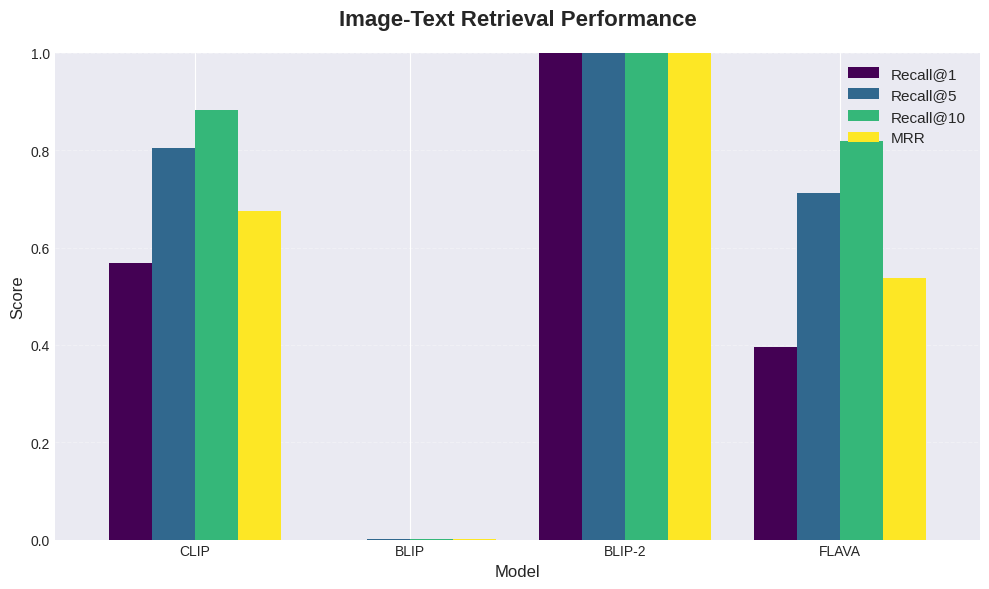

  ✓ Saved: 1_retrieval_performance.png

📊 Creating Classification Performance plot...


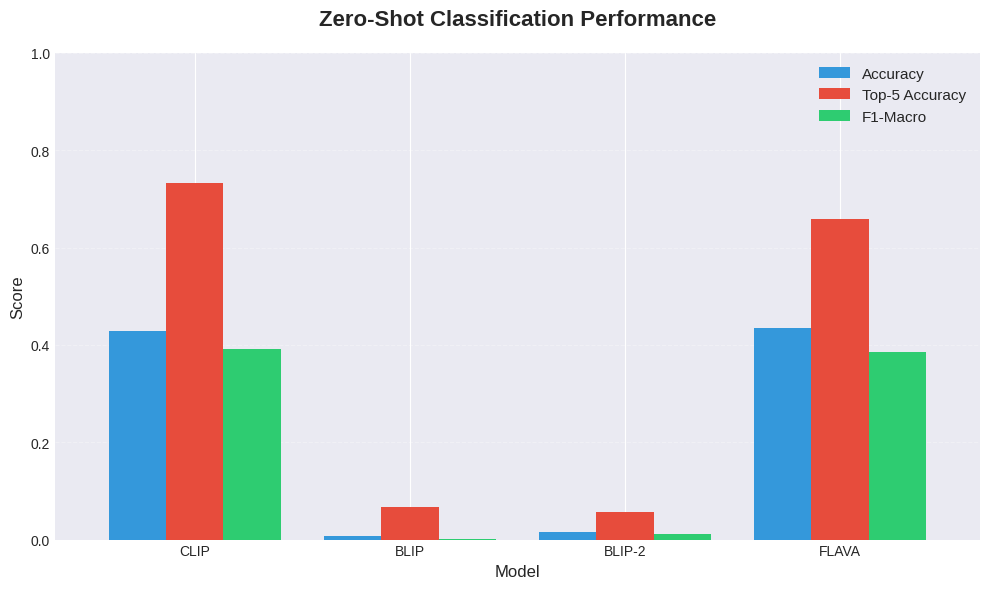

  ✓ Saved: 2_classification_performance.png

📊 Creating Captioning Performance plot...


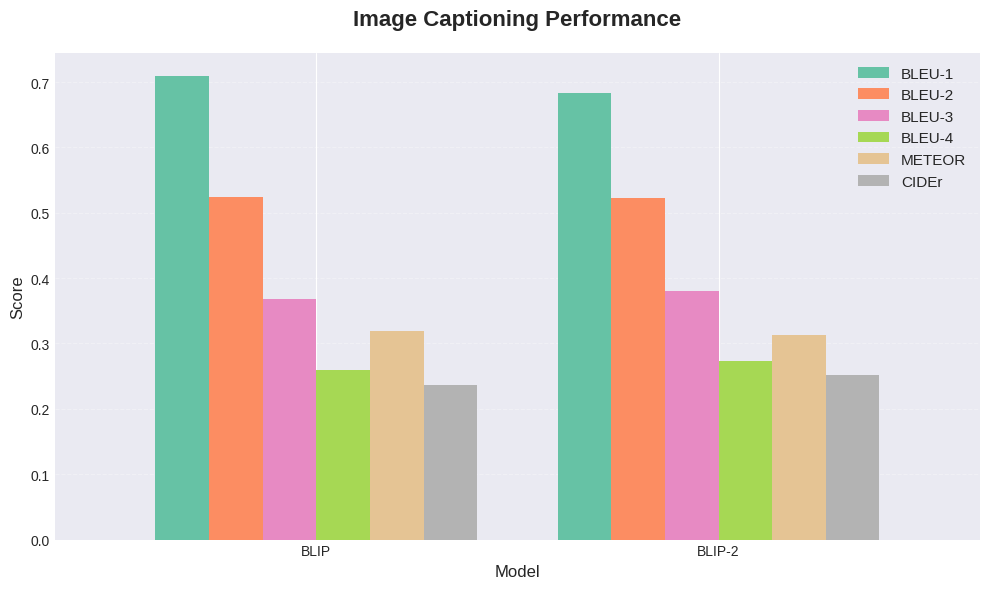

  ✓ Saved: 3_captioning_performance.png

📊 Creating Latency plot...


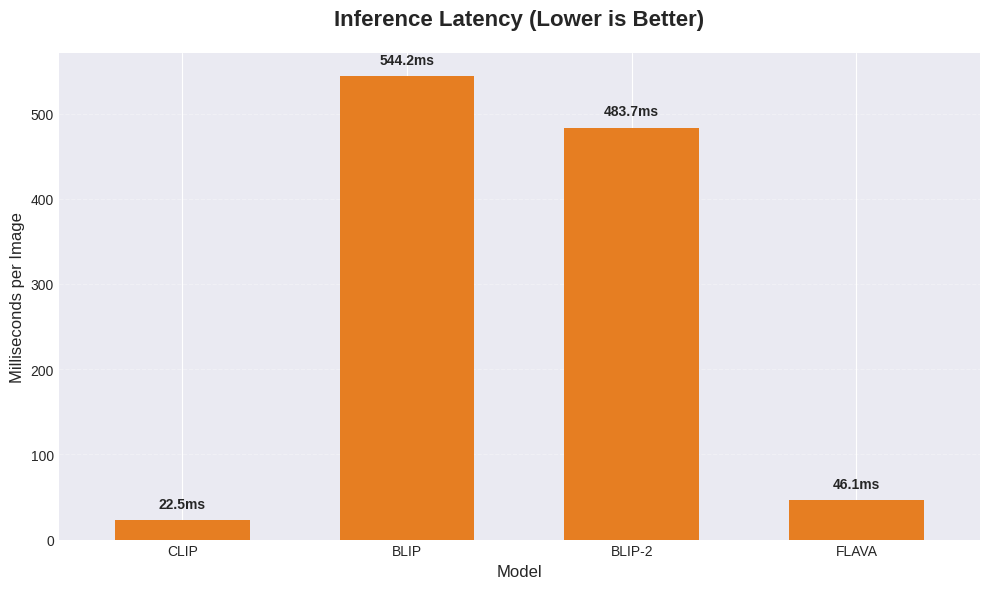

  ✓ Saved: 4_latency.png

📊 Creating Memory Usage plot...


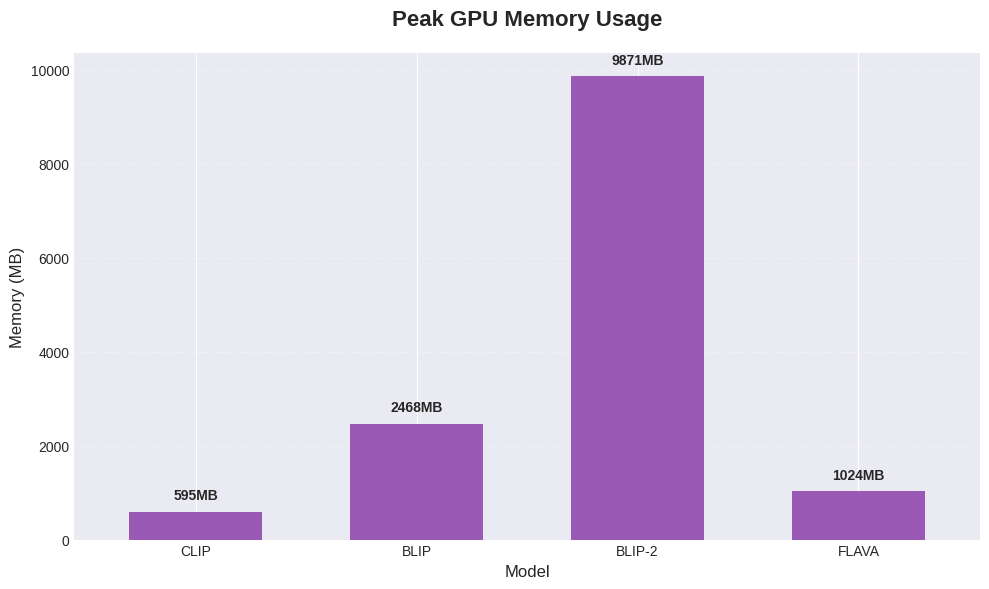

  ✓ Saved: 5_memory_usage.png

📊 Creating Throughput plot...


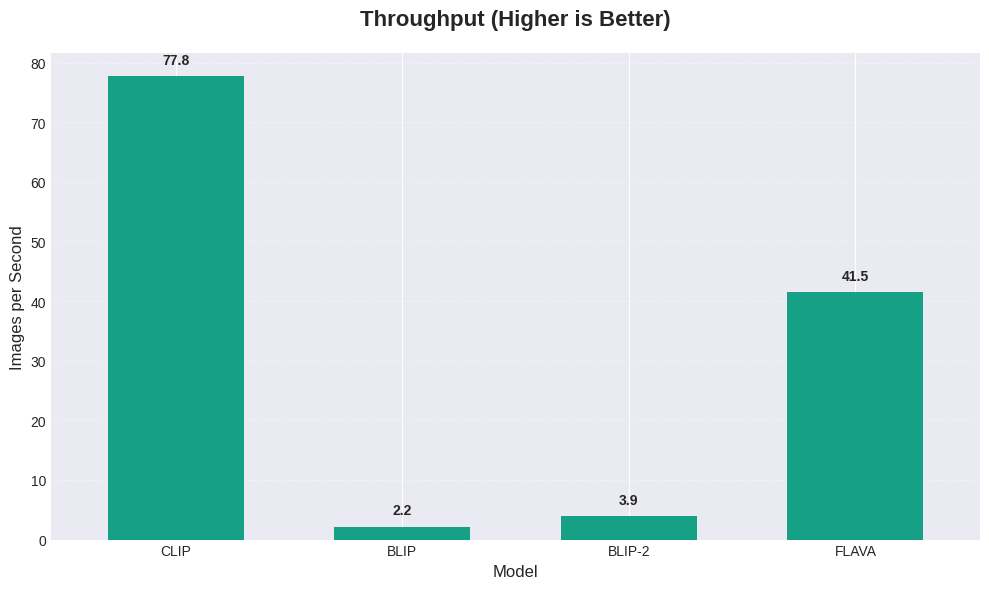

  ✓ Saved: 6_throughput.png

✓ VISUALIZATION COMPLETE

Saved plots to: /kaggle/working/vlm_benchmark_storage/plots


In [20]:
# ============================================================================
# SEPARATE VISUALIZATIONS FOR ALL MODELS
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

print("\n" + "="*60)
print("CREATING INDIVIDUAL VISUALIZATIONS")
print("="*60)

# Set default style
plt.style.use('seaborn-v0_8-darkgrid')
FIGSIZE = (10, 6)

# ============================================================================
# 1. RETRIEVAL PERFORMANCE
# ============================================================================

print("\n📊 Creating Retrieval Performance plot...")
fig, ax = plt.subplots(figsize=FIGSIZE)
retrieval_metrics = ['Retrieval_recall@1', 'Retrieval_recall@5', 'Retrieval_recall@10', 'Retrieval_mrr']

# Filter out models with no retrieval data
retrieval_data = results_df[results_df['Retrieval_recall@5'].notna()][['Model'] + retrieval_metrics].set_index('Model')

if len(retrieval_data) > 0:
    retrieval_data.plot(kind='bar', ax=ax, colormap='viridis', width=0.8)
    ax.set_title('Image-Text Retrieval Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.legend(['Recall@1', 'Recall@5', 'Recall@10', 'MRR'], loc='best', fontsize=11, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '1_retrieval_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 1_retrieval_performance.png")
else:
    print("  ⚠️ No retrieval data available")

# ============================================================================
# 2. CLASSIFICATION PERFORMANCE
# ============================================================================

print("\n📊 Creating Classification Performance plot...")
fig, ax = plt.subplots(figsize=FIGSIZE)
class_metrics = ['Classification_accuracy', 'Classification_top5_accuracy', 'Classification_f1_macro']

# Filter out models with no classification data
class_data = results_df[results_df['Classification_accuracy'].notna()][['Model'] + class_metrics].set_index('Model')

if len(class_data) > 0:
    class_data.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
    ax.set_title('Zero-Shot Classification Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.legend(['Accuracy', 'Top-5 Accuracy', 'F1-Macro'], loc='best', fontsize=11, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '2_classification_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 2_classification_performance.png")
else:
    print("  ⚠️ No classification data available")

# ============================================================================
# 3. CAPTIONING PERFORMANCE
# ============================================================================

print("\n📊 Creating Captioning Performance plot...")
caption_models = results_df[results_df['Captioning_bleu4'].notna()]

if len(caption_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    caption_metrics = ['Captioning_bleu1', 'Captioning_bleu2', 'Captioning_bleu3', 
                       'Captioning_bleu4', 'Captioning_meteor', 'Captioning_cider']
    caption_data = caption_models[['Model'] + caption_metrics].set_index('Model')
    caption_data.plot(kind='bar', ax=ax, colormap='Set2', width=0.8)
    ax.set_title('Image Captioning Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.legend(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'METEOR', 'CIDEr'], 
              loc='best', fontsize=11, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '3_captioning_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 3_captioning_performance.png")
else:
    print("  ⚠️ No captioning data available")

# ============================================================================
# 4. INFERENCE LATENCY
# ============================================================================

print("\n📊 Creating Latency plot...")
fig, ax = plt.subplots(figsize=FIGSIZE)
latency_data = results_df[results_df['Efficiency_latency_ms'].notna()][['Model', 'Efficiency_latency_ms']].set_index('Model')

if len(latency_data) > 0:
    latency_data.plot(kind='bar', ax=ax, color='#e67e22', width=0.6, legend=False)
    ax.set_title('Inference Latency (Lower is Better)', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Milliseconds per Image', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(latency_data['Efficiency_latency_ms']):
        ax.text(i, v + max(latency_data['Efficiency_latency_ms'])*0.02, f'{v:.1f}ms', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '4_latency.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 4_latency.png")

# ============================================================================
# 5. GPU MEMORY USAGE
# ============================================================================

print("\n📊 Creating Memory Usage plot...")
fig, ax = plt.subplots(figsize=FIGSIZE)
memory_data = results_df[results_df['Efficiency_memory_mb'].notna()][['Model', 'Efficiency_memory_mb']].set_index('Model')

if len(memory_data) > 0:
    memory_data.plot(kind='bar', ax=ax, color='#9b59b6', width=0.6, legend=False)
    ax.set_title('Peak GPU Memory Usage', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Memory (MB)', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(memory_data['Efficiency_memory_mb']):
        ax.text(i, v + max(memory_data['Efficiency_memory_mb'])*0.02, f'{v:.0f}MB', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '5_memory_usage.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 5_memory_usage.png")

# ============================================================================
# 6. THROUGHPUT
# ============================================================================

print("\n📊 Creating Throughput plot...")
fig, ax = plt.subplots(figsize=FIGSIZE)
throughput_data = results_df[results_df['Efficiency_throughput'].notna()][['Model', 'Efficiency_throughput']].set_index('Model')

if len(throughput_data) > 0:
    throughput_data.plot(kind='bar', ax=ax, color='#16a085', width=0.6, legend=False)
    ax.set_title('Throughput (Higher is Better)', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Images per Second', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(throughput_data['Efficiency_throughput']):
        ax.text(i, v + max(throughput_data['Efficiency_throughput'])*0.02, f'{v:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '6_throughput.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 6_throughput.png")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("✓ VISUALIZATION COMPLETE")
print("="*60)
print(f"\nSaved plots to: {PLOTS_DIR}")


CREATING INDIVIDUAL VISUALIZATIONS

📊 Loading results data...
  ✓ Loaded CLIP
  ✓ Loaded BLIP
  ✓ Loaded BLIP2
  ✓ Loaded FLAVA
✓ Loaded 4 models

📊 Plot 1: Retrieval Performance


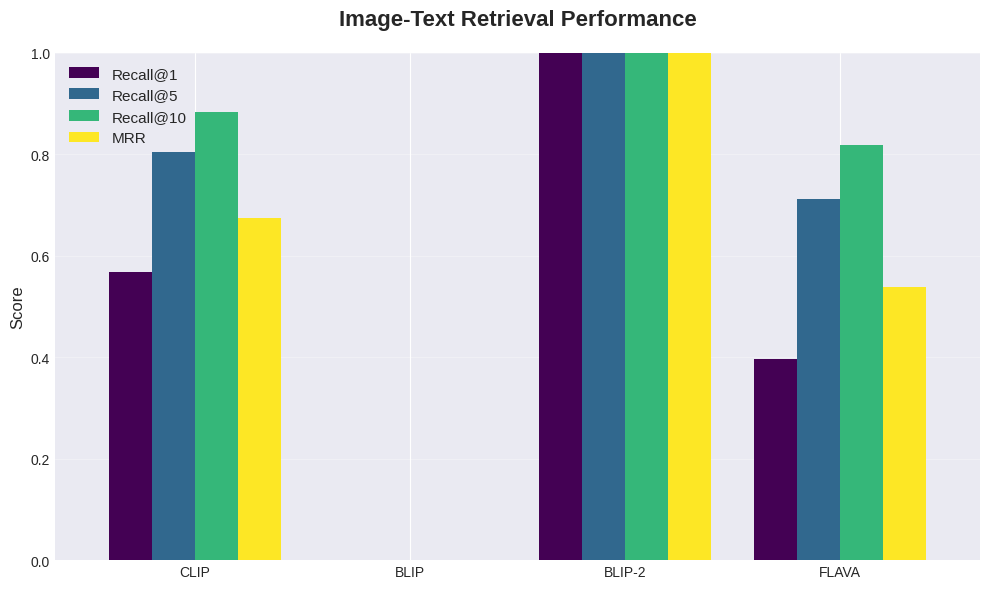

  ✓ Saved: 1_retrieval_performance.png

📊 Plot 2: Classification Performance


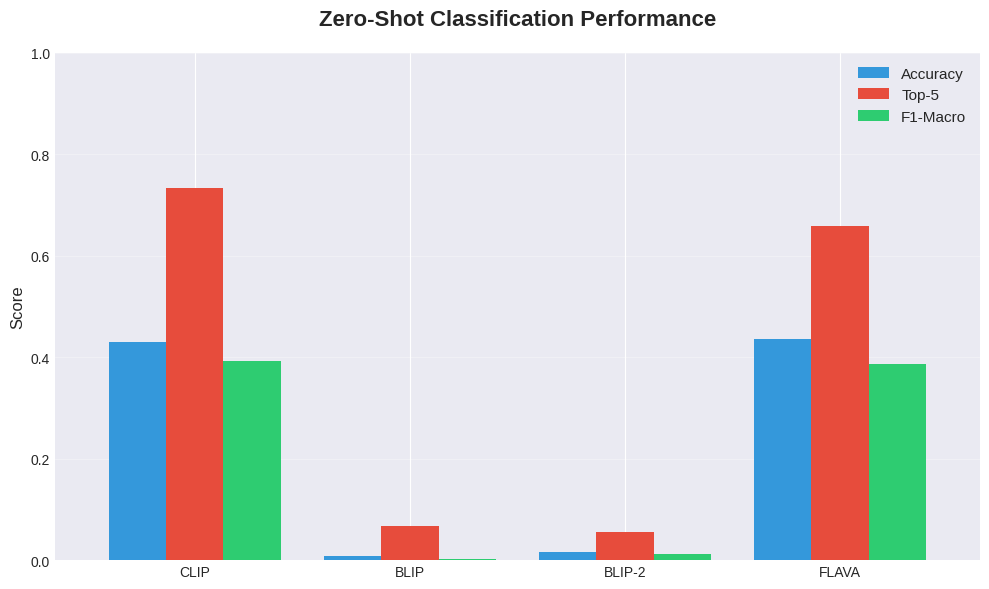

  ✓ Saved: 2_classification_performance.png

📊 Plot 3: Captioning Performance


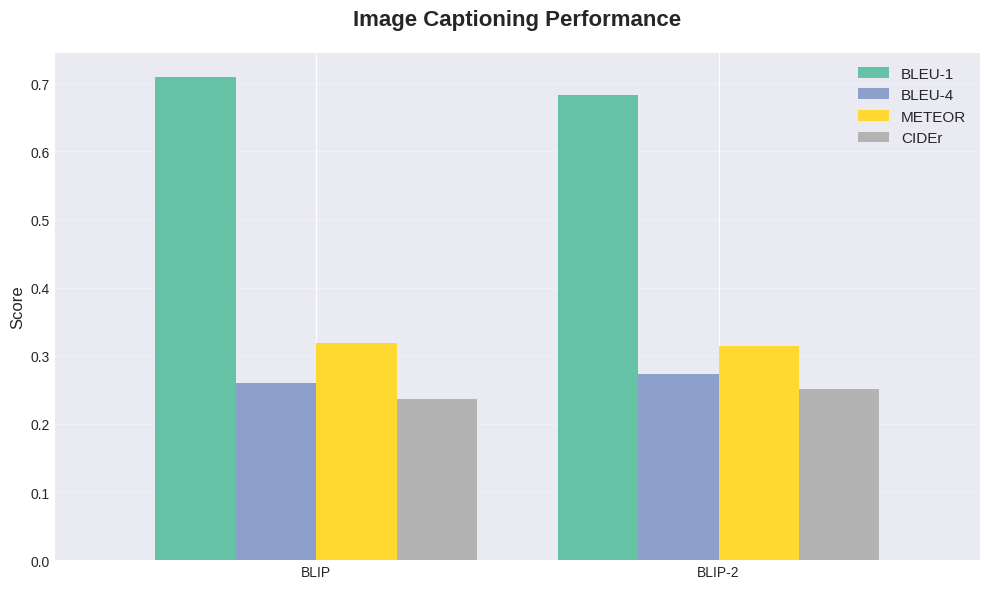

  ✓ Saved: 3_captioning_performance.png

📊 Plot 4: Inference Latency


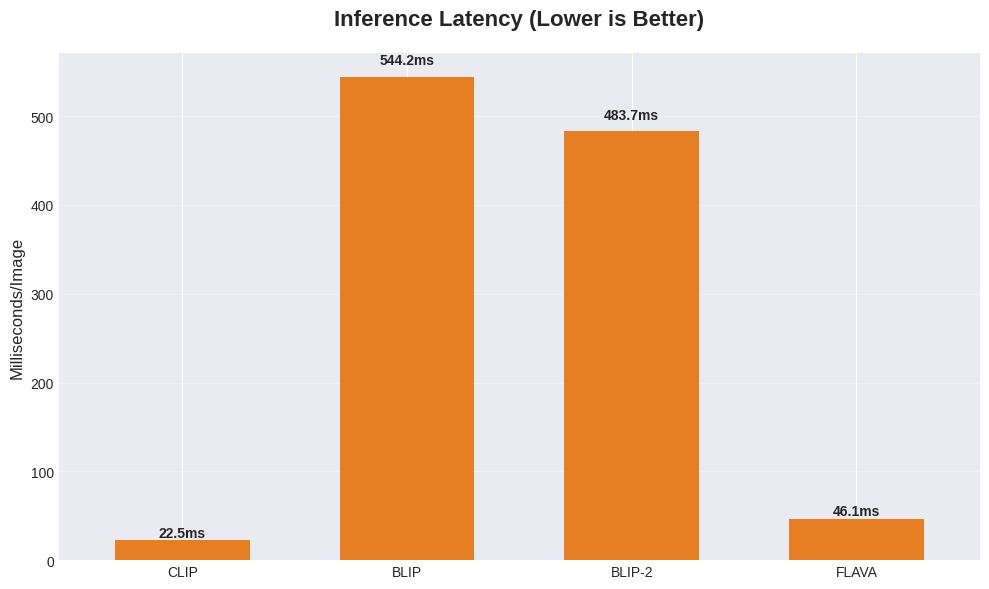

  ✓ Saved: 4_latency.png

📊 Plot 5: GPU Memory Usage


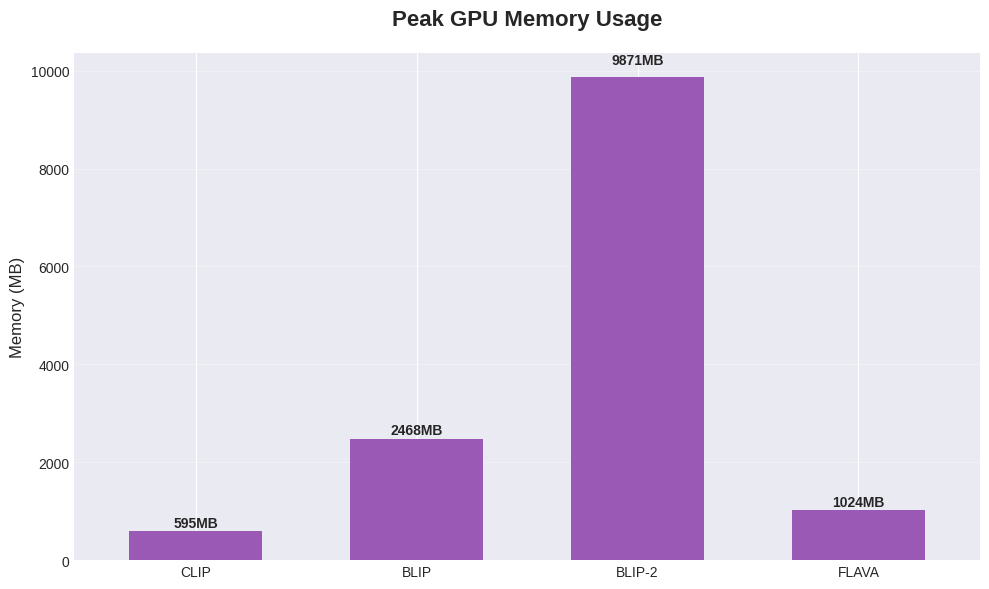

  ✓ Saved: 5_memory_usage.png

📊 Plot 6: Throughput


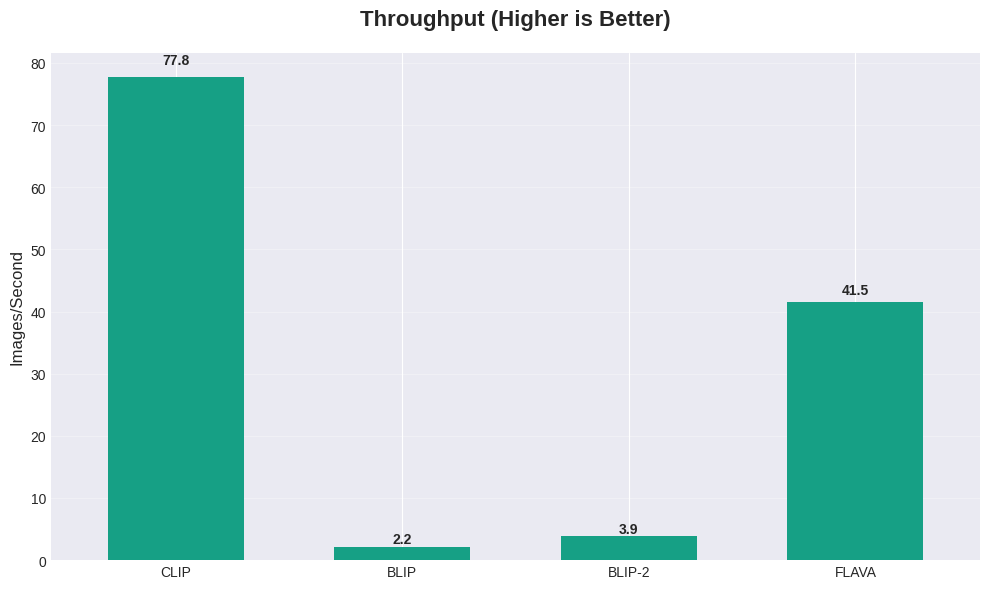

  ✓ Saved: 6_throughput.png

📊 Plot 7: Calibration Error


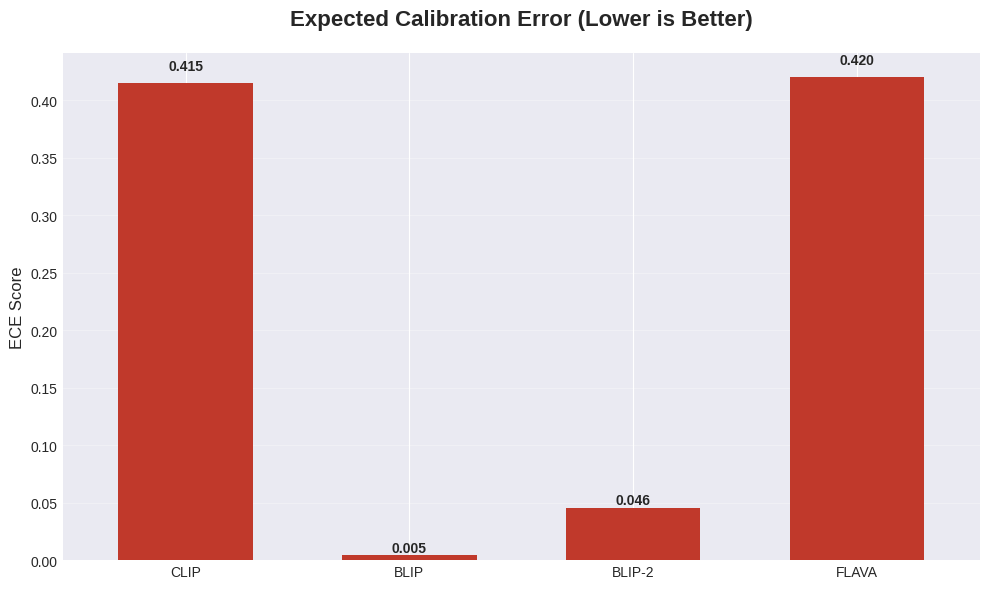

  ✓ Saved: 7_calibration_error.png

📊 Plot 8: Median Rank


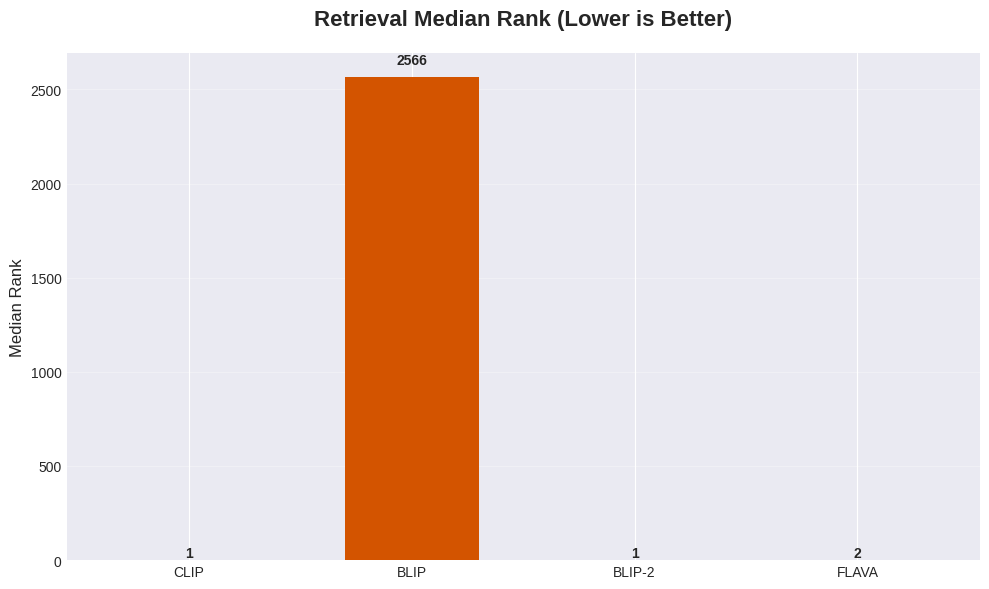

  ✓ Saved: 8_median_rank.png

📊 Plot 9: Radar Chart - Overall Comparison


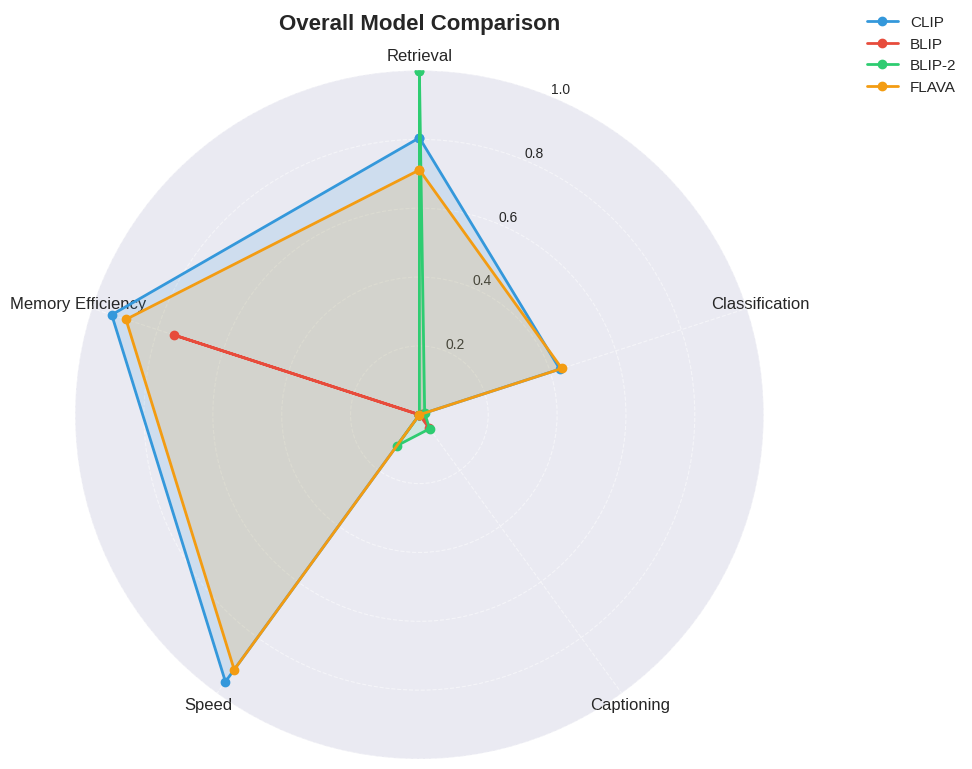

  ✓ Saved: 9_radar_chart.png

📊 Plot 10: Efficiency vs Performance Scatter


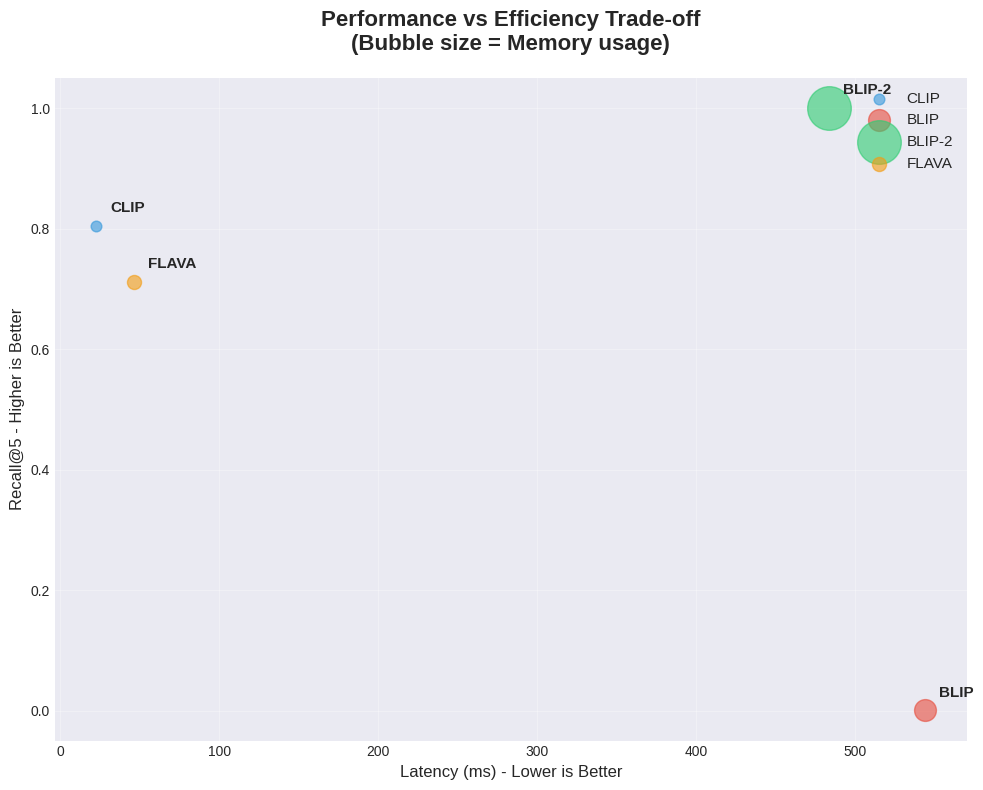

  ✓ Saved: 10_efficiency_vs_performance.png

📊 Plot 11: Overall Composite Score


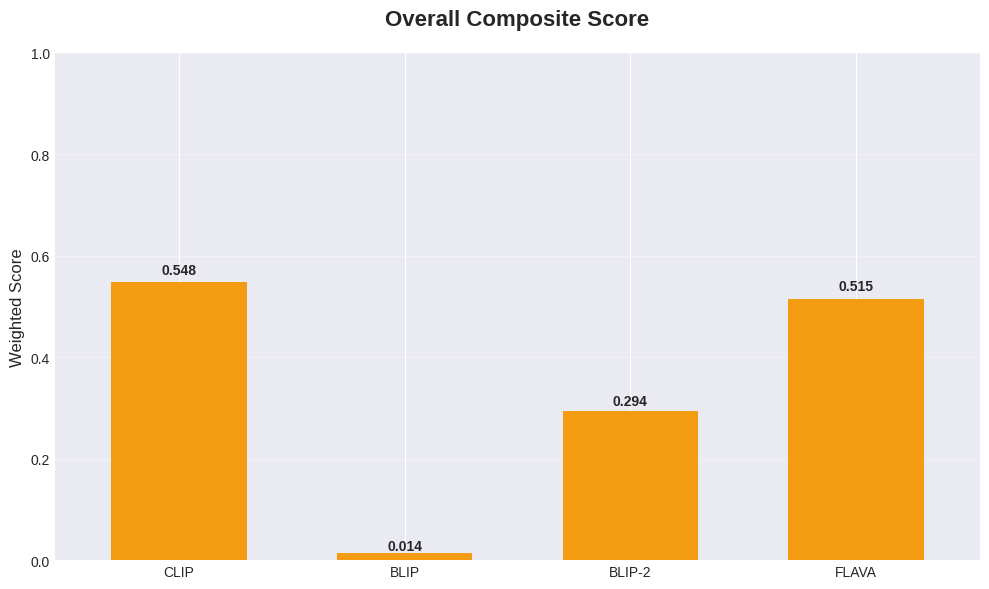

  ✓ Saved: 11_overall_composite_score.png

✓ ALL VISUALIZATIONS CREATED

Saved 11 individual plots to: /kaggle/working/vlm_benchmark_storage/plots

Files created:
   1. Plot saved as PNG
   2. Plot saved as PNG
   3. Plot saved as PNG
   4. Plot saved as PNG
   5. Plot saved as PNG
   6. Plot saved as PNG
   7. Plot saved as PNG
   8. Plot saved as PNG
   9. Plot saved as PNG
  10. Plot saved as PNG
  11. Plot saved as PNG

✓ Complete!


In [21]:
# ============================================================================
# COMPLETE INDIVIDUAL VISUALIZATIONS WITH SEPARATE IMAGES
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi
import os
import json

print("\n" + "="*60)
print("CREATING INDIVIDUAL VISUALIZATIONS")
print("="*60)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
FIGSIZE = (10, 6)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n📊 Loading results data...")

def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

all_results = []
for model_name in ['clip', 'blip', 'blip2', 'flava']:
    result_file = os.path.join(RESULTS_DIR, f'{model_name}_results.json')
    if os.path.exists(result_file):
        results = load_json(result_file)
        all_results.append(results)
        print(f"  ✓ Loaded {model_name.upper()}")

# Create DataFrame
data_rows = []
for results in all_results:
    row = {'Model': results['model']}
    
    if results.get('retrieval'):
        row['Retrieval_recall@1'] = results['retrieval'].get('recall@1', None)
        row['Retrieval_recall@5'] = results['retrieval'].get('recall@5', None)
        row['Retrieval_recall@10'] = results['retrieval'].get('recall@10', None)
        row['Retrieval_mrr'] = results['retrieval'].get('mrr', None)
        row['Retrieval_median_rank'] = results['retrieval'].get('median_rank', None)
    
    if results.get('classification'):
        row['Classification_accuracy'] = results['classification'].get('accuracy', None)
        row['Classification_top5_accuracy'] = results['classification'].get('top5_accuracy', None)
        row['Classification_f1_macro'] = results['classification'].get('f1_macro', None)
        row['Classification_ece'] = results['classification'].get('ece', None)
    
    if results.get('captioning'):
        row['Captioning_bleu1'] = results['captioning'].get('bleu1', None)
        row['Captioning_bleu4'] = results['captioning'].get('bleu4', None)
        row['Captioning_meteor'] = results['captioning'].get('meteor', None)
        row['Captioning_cider'] = results['captioning'].get('cider', None)
    
    if results.get('efficiency'):
        row['Efficiency_latency_ms'] = results['efficiency'].get('latency_ms', None)
        row['Efficiency_memory_mb'] = results['efficiency'].get('memory_mb', None)
        row['Efficiency_throughput'] = results['efficiency'].get('throughput', None)
    
    data_rows.append(row)

results_df = pd.DataFrame(data_rows)
print(f"✓ Loaded {len(results_df)} models\n")

# ============================================================================
# 1. RETRIEVAL PERFORMANCE
# ============================================================================

print("📊 Plot 1: Retrieval Performance")
retrieval_models = results_df[results_df['Retrieval_recall@5'].notna()]

if len(retrieval_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    metrics = ['Retrieval_recall@1', 'Retrieval_recall@5', 'Retrieval_recall@10', 'Retrieval_mrr']
    data = retrieval_models[['Model'] + metrics].set_index('Model')
    data.plot(kind='bar', ax=ax, colormap='viridis', width=0.8)
    ax.set_title('Image-Text Retrieval Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('')
    ax.legend(['Recall@1', 'Recall@5', 'Recall@10', 'MRR'], fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '1_retrieval_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 1_retrieval_performance.png\n")

# ============================================================================
# 2. CLASSIFICATION PERFORMANCE
# ============================================================================

print("📊 Plot 2: Classification Performance")
class_models = results_df[results_df['Classification_accuracy'].notna()]

if len(class_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    metrics = ['Classification_accuracy', 'Classification_top5_accuracy', 'Classification_f1_macro']
    data = class_models[['Model'] + metrics].set_index('Model')
    data.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
    ax.set_title('Zero-Shot Classification Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('')
    ax.legend(['Accuracy', 'Top-5', 'F1-Macro'], fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '2_classification_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 2_classification_performance.png\n")

# ============================================================================
# 3. CAPTIONING PERFORMANCE
# ============================================================================

print("📊 Plot 3: Captioning Performance")
caption_models = results_df[results_df['Captioning_bleu4'].notna()]

if len(caption_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    metrics = ['Captioning_bleu1', 'Captioning_bleu4', 'Captioning_meteor', 'Captioning_cider']
    data = caption_models[['Model'] + metrics].set_index('Model')
    data.plot(kind='bar', ax=ax, colormap='Set2', width=0.8)
    ax.set_title('Image Captioning Performance', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('')
    ax.legend(['BLEU-1', 'BLEU-4', 'METEOR', 'CIDEr'], fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '3_captioning_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 3_captioning_performance.png\n")

# ============================================================================
# 4. LATENCY
# ============================================================================

print("📊 Plot 4: Inference Latency")
fig, ax = plt.subplots(figsize=FIGSIZE)
data = results_df[['Model', 'Efficiency_latency_ms']].set_index('Model')
data.plot(kind='bar', ax=ax, color='#e67e22', width=0.6, legend=False)
ax.set_title('Inference Latency (Lower is Better)', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel('Milliseconds/Image', fontsize=12)
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(data['Efficiency_latency_ms'].items()):
    ax.text(i, v*1.02, f'{v:.1f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '4_latency.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 4_latency.png\n")

# ============================================================================
# 5. MEMORY
# ============================================================================

print("📊 Plot 5: GPU Memory Usage")
fig, ax = plt.subplots(figsize=FIGSIZE)
data = results_df[['Model', 'Efficiency_memory_mb']].set_index('Model')
data.plot(kind='bar', ax=ax, color='#9b59b6', width=0.6, legend=False)
ax.set_title('Peak GPU Memory Usage', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel('Memory (MB)', fontsize=12)
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(data['Efficiency_memory_mb'].items()):
    ax.text(i, v*1.02, f'{v:.0f}MB', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '5_memory_usage.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 5_memory_usage.png\n")

# ============================================================================
# 6. THROUGHPUT
# ============================================================================

print("📊 Plot 6: Throughput")
fig, ax = plt.subplots(figsize=FIGSIZE)
data = results_df[['Model', 'Efficiency_throughput']].set_index('Model')
data.plot(kind='bar', ax=ax, color='#16a085', width=0.6, legend=False)
ax.set_title('Throughput (Higher is Better)', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel('Images/Second', fontsize=12)
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)
for i, (idx, v) in enumerate(data['Efficiency_throughput'].items()):
    ax.text(i, v*1.02, f'{v:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '6_throughput.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 6_throughput.png\n")

# ============================================================================
# 7. CALIBRATION ERROR
# ============================================================================

print("📊 Plot 7: Calibration Error")
ece_models = results_df[results_df['Classification_ece'].notna()]

if len(ece_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    data = ece_models[['Model', 'Classification_ece']].set_index('Model')
    data.plot(kind='bar', ax=ax, color='#c0392b', width=0.6, legend=False)
    ax.set_title('Expected Calibration Error (Lower is Better)', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('ECE Score', fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
    for i, (idx, v) in enumerate(data['Classification_ece'].items()):
        ax.text(i, v*1.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '7_calibration_error.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 7_calibration_error.png\n")

# ============================================================================
# 8. MEDIAN RANK
# ============================================================================

print("📊 Plot 8: Median Rank")
rank_models = results_df[results_df['Retrieval_median_rank'].notna()]

if len(rank_models) > 0:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    data = rank_models[['Model', 'Retrieval_median_rank']].set_index('Model')
    data.plot(kind='bar', ax=ax, color='#d35400', width=0.6, legend=False)
    ax.set_title('Retrieval Median Rank (Lower is Better)', fontweight='bold', fontsize=16, pad=20)
    ax.set_ylabel('Median Rank', fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
    for i, (idx, v) in enumerate(data['Retrieval_median_rank'].items()):
        ax.text(i, v*1.02, f'{v:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '8_median_rank.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: 8_median_rank.png\n")

# ============================================================================
# 9. RADAR CHART
# ============================================================================

print("📊 Plot 9: Radar Chart - Overall Comparison")
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Retrieval', 'Classification', 'Captioning', 'Speed', 'Memory Efficiency']
models = results_df['Model'].tolist()

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.grid(True, linestyle='--', alpha=0.5)

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, model in enumerate(models):
    row = results_df[results_df['Model'] == model].iloc[0]
    
    values = [
        row['Retrieval_recall@5'] if pd.notna(row.get('Retrieval_recall@5')) else 0,
        row['Classification_accuracy'] if pd.notna(row.get('Classification_accuracy')) else 0,
        row['Captioning_cider'] / 5.0 if pd.notna(row.get('Captioning_cider')) else 0,
        1 - (row['Efficiency_latency_ms'] / results_df['Efficiency_latency_ms'].max()),
        1 - (row['Efficiency_memory_mb'] / results_df['Efficiency_memory_mb'].max())
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_title('Overall Model Comparison', fontweight='bold', fontsize=16, pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '9_radar_chart.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 9_radar_chart.png\n")

# ============================================================================
# 10. EFFICIENCY vs PERFORMANCE SCATTER
# ============================================================================

print("📊 Plot 10: Efficiency vs Performance Scatter")
fig, ax = plt.subplots(figsize=(10, 8))

for idx, row in results_df.iterrows():
    if pd.notna(row['Retrieval_recall@5']):
        ax.scatter(row['Efficiency_latency_ms'], row['Retrieval_recall@5'], 
                   s=row['Efficiency_memory_mb']/10, alpha=0.6, 
                   color=colors[idx], label=row['Model'])
        ax.annotate(row['Model'], 
                    (row['Efficiency_latency_ms'], row['Retrieval_recall@5']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')

ax.set_xlabel('Latency (ms) - Lower is Better', fontsize=12)
ax.set_ylabel('Recall@5 - Higher is Better', fontsize=12)
ax.set_title('Performance vs Efficiency Trade-off\n(Bubble size = Memory usage)', 
             fontweight='bold', fontsize=16, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '10_efficiency_vs_performance.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 10_efficiency_vs_performance.png\n")

# ============================================================================
# 11. OVERALL COMPOSITE SCORE
# ============================================================================

print("📊 Plot 11: Overall Composite Score")
fig, ax = plt.subplots(figsize=FIGSIZE)

composite_scores = []
for _, row in results_df.iterrows():
    score = (
        (row['Retrieval_recall@5'] if pd.notna(row.get('Retrieval_recall@5')) else 0) * 0.25 +
        (row['Classification_accuracy'] if pd.notna(row.get('Classification_accuracy')) else 0) * 0.25 +
        (row['Captioning_cider'] / 5.0 if pd.notna(row.get('Captioning_cider')) else 0) * 0.25 +
        (1 - row['Efficiency_latency_ms'] / results_df['Efficiency_latency_ms'].max()) * 0.25
    )
    composite_scores.append(score)

score_df = pd.DataFrame({
    'Model': results_df['Model'],
    'Composite_Score': composite_scores
}).set_index('Model')

score_df.plot(kind='bar', ax=ax, color='#f39c12', width=0.6, legend=False)
ax.set_title('Overall Composite Score', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel('Weighted Score', fontsize=12)
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])
for i, (idx, v) in enumerate(score_df['Composite_Score'].items()):
    ax.text(i, v*1.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '11_overall_composite_score.png'), dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 11_overall_composite_score.png\n")

# ============================================================================
# SUMMARY
# ============================================================================

print("="*60)
print("✓ ALL VISUALIZATIONS CREATED")
print("="*60)
print(f"\nSaved 11 individual plots to: {PLOTS_DIR}\n")
print("Files created:")
for i in range(1, 12):
    print(f"  {i:2d}. Plot saved as PNG")
print("\n✓ Complete!")

In [22]:
# ============================================================================
# CREATE DOWNLOADABLE ARCHIVE OF ALL RESULTS
# ============================================================================

import shutil

# Create archive
archive_name = '/kaggle/working/vlm_benchmark_complete'
shutil.make_archive(archive_name, 'zip', STORAGE_ROOT)

print(f"\n✓ Complete benchmark archive created: {archive_name}.zip")
print(f"\n📁 Archive contains:")
print(f"  - All embeddings (.npy files)")
print(f"  - All captions (.txt files)")
print(f"  - All results (.json files)")
print(f"  - All plots (.png files)")
print(f"  - Comparison table (.csv file)")
print(f"\n💾 Download this file to preserve all results!")


✓ Complete benchmark archive created: /kaggle/working/vlm_benchmark_complete.zip

📁 Archive contains:
  - All embeddings (.npy files)
  - All captions (.txt files)
  - All results (.json files)
  - All plots (.png files)
  - Comparison table (.csv file)

💾 Download this file to preserve all results!
